In [1]:
# Import required modules
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from wordcloud import WordCloud
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.special import rel_entr

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Use ggplot
matplotlib.style.use('ggplot')

features = ['target_material','target_thickness','pulse_width','energy','spot_size','intensity','power','cutoff_energy']
numeric_features = ['target_thickness', 'pulse_width', 'energy', 'spot_size', 'intensity', 'power', 'cutoff_energy']

# Load original dataset that was used to generate samples
df_original = pd.read_csv('../1_sample_preparation/source/d_clean_remove_small_samples.csv')
# Make sure required features are numeric
df_original[numeric_features] = df_original[numeric_features].astype(float)
df_original.reset_index(drop=True,inplace=True)

# Load synthetic data set
df_synthetic = pd.read_csv('../4_response_extraction/synthetic_data_rows.csv')
# Drop column
df_synthetic.drop(columns=['Unnamed: 0'],inplace=True)
# Make sure required features are numeric
df_synthetic[numeric_features] = df_synthetic[numeric_features].astype(float)
df_synthetic.reset_index(drop=True,inplace=True)

# Create a copy of the original DataFrame
df_remove_outliers_raw = df_synthetic.copy()
df_remove_outliers_ipr = df_synthetic.copy()
df_remove_outliers_iqr = df_synthetic.copy()

# Function to remove outliers for a specific feature
def remove_outliers(df, feature, lower_percentile, upper_percentile):
    Q1 = df[feature].quantile(lower_percentile)
    Q3 = df[feature].quantile(upper_percentile)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]

# Remove outliers for all numeric features
for nf in numeric_features:
    df_remove_outliers_raw = remove_outliers(df_remove_outliers_raw, nf, 0.005, 0.995)
    df_remove_outliers_ipr = remove_outliers(df_remove_outliers_ipr, nf, 0.10, 0.90)
    df_remove_outliers_iqr = remove_outliers(df_remove_outliers_iqr, nf, 0.25, 0.75)

print(f"Original DataFrame length: {len(df_synthetic)}")
print(f"DataFrame length after removing outliers 'RAW' for Inf values: {len(df_remove_outliers_raw)} - Rows lost: {len(df_synthetic) - len(df_remove_outliers_raw)}")
print(f"DataFrame length after removing outliers IPR: {len(df_remove_outliers_ipr)} - Rows lost: {len(df_synthetic) - len(df_remove_outliers_ipr)}")
print(f"DataFrame length after removing outliers IQR: {len(df_remove_outliers_iqr)} - Rows lost: {len(df_synthetic) - len(df_remove_outliers_iqr)}")

df_synthetic.head()

Original DataFrame length: 163300
DataFrame length after removing outliers 'RAW' for Inf values: 159860 - Rows lost: 3440
DataFrame length after removing outliers IPR: 131478 - Rows lost: 31822
DataFrame length after removing outliers IQR: 62513 - Rows lost: 100787


model     prompt_method prompt_short sample_size  \
0  claude-3-5-sonnet-20240620  chain_of_thought          cot   rs_size_5   
1  claude-3-5-sonnet-20240620  chain_of_thought          cot   rs_size_5   
2  claude-3-5-sonnet-20240620  chain_of_thought          cot   rs_size_5   
3  claude-3-5-sonnet-20240620  chain_of_thought          cot   rs_size_5   
4  claude-3-5-sonnet-20240620  chain_of_thought          cot   rs_size_5   

  target_material  target_thickness  pulse_width  energy  spot_size  \
0         plastic             0.301         35.0    1.87        3.3   
1            gold             0.685        180.0    3.25        3.3   
2       aluminium             0.952         42.0    2.39        3.3   
3   polypropylene             1.230        320.0   15.60        4.1   
4         plastic             0.488         30.0    2.33        3.3   

      intensity         power  cutoff_energy  
0  5.120000e+20  5.340000e+13            4.2  
1  7.210000e+20  1.810000e+13            6.8  
2  6.380000e+20  5.690000e+13            5.1  
3  1.450000e+21  4.880000e+13           18.3  
4  6.300000e+20  7.770000e+13            4.5

In [2]:
df_original.head()

target_material  target_thickness  pulse_width  energy  spot_size  \
0         plastic             0.537         30.0   2.427        3.3   
1         plastic             0.293         30.0   2.395        3.3   
2         plastic             0.610         30.0   2.425        3.3   
3         plastic             0.509         30.0   2.344        3.3   
4         plastic             0.527         30.0   2.351        3.3   

      intensity         power  cutoff_energy  
0  6.561000e+20  8.091000e+13            3.3  
1  6.473000e+20  7.983000e+13            3.4  
2  6.554000e+20  8.083000e+13            3.4  
3  6.335000e+20  7.813000e+13            3.4  
4  6.356000e+20  7.838000e+13            3.4

Unique Materials: 447


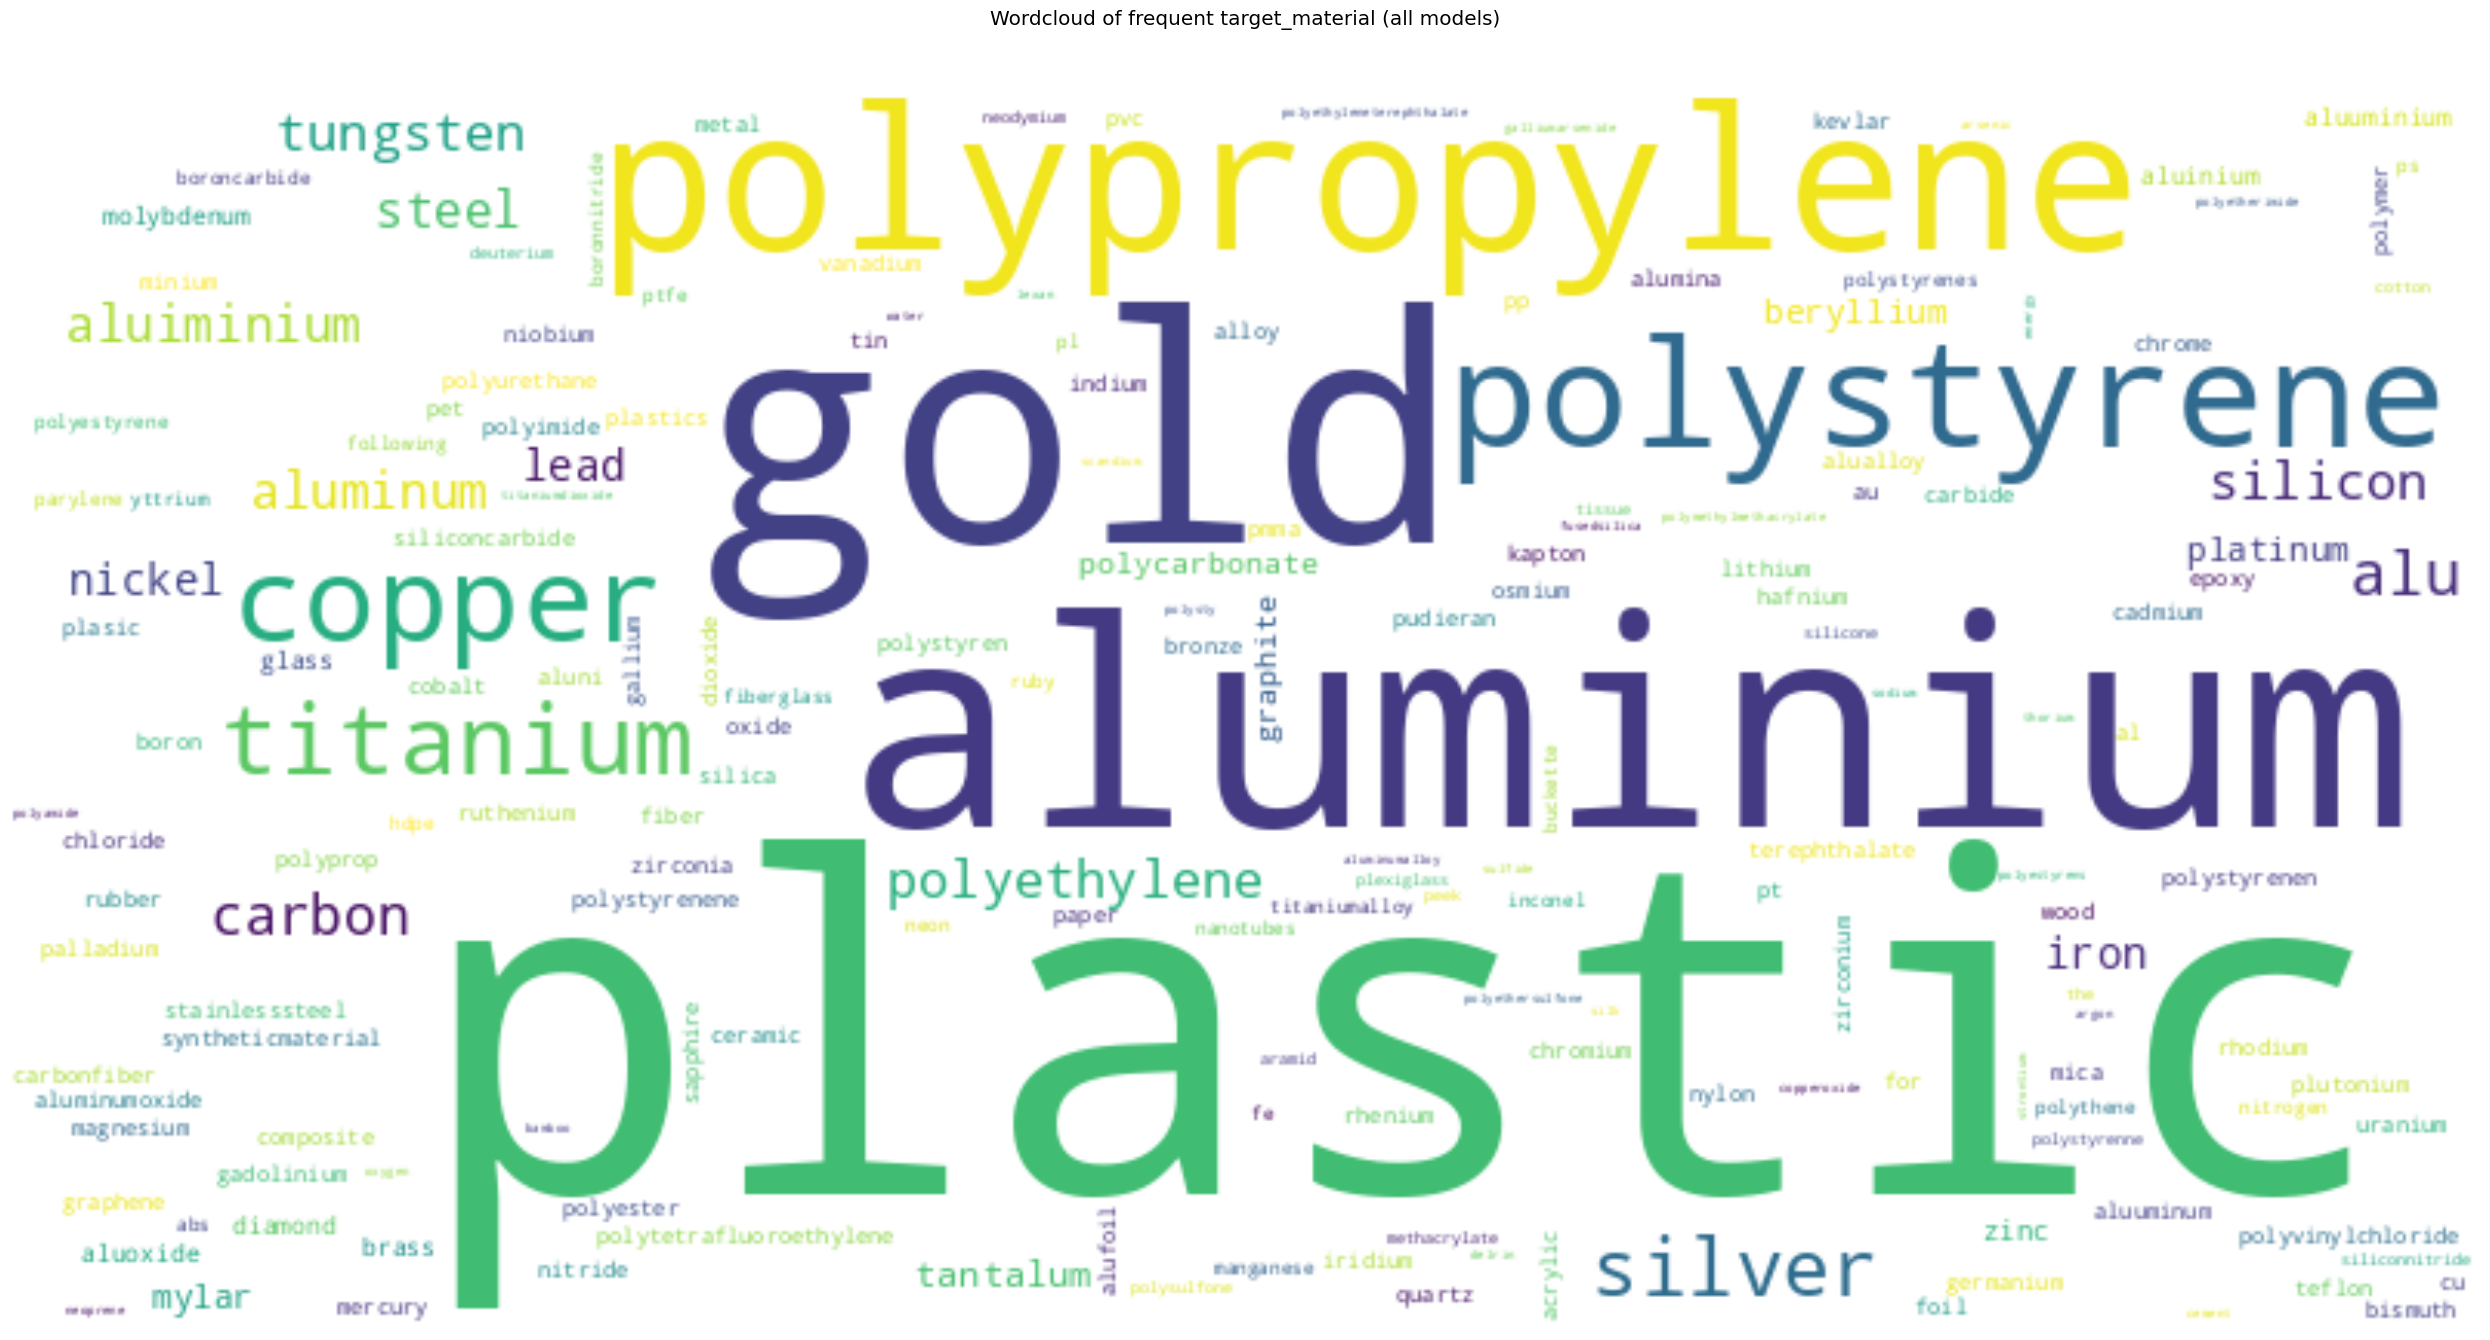

In [3]:
# Count the occurrences of each 'target_material'
material_counts = df_remove_outliers_raw['target_material'].value_counts()

print('Unique Materials:',len(df_remove_outliers_raw['target_material'].unique()))

# Create a WordCloud object
wordcloud = WordCloud(width = 800, height = 400, background_color ='white')

# Generate a word cloud using the frequencies
wordcloud.generate_from_frequencies(material_counts.to_dict())

# Display the WordCloud image:
plt.figure(figsize=(25, 15))
plt.title('Wordcloud of frequent target_material (all models)',y=1.05)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels

plt.tight_layout()

plt.savefig('./images/word_cloud_target_material.jpg',dpi=800)
plt.show()

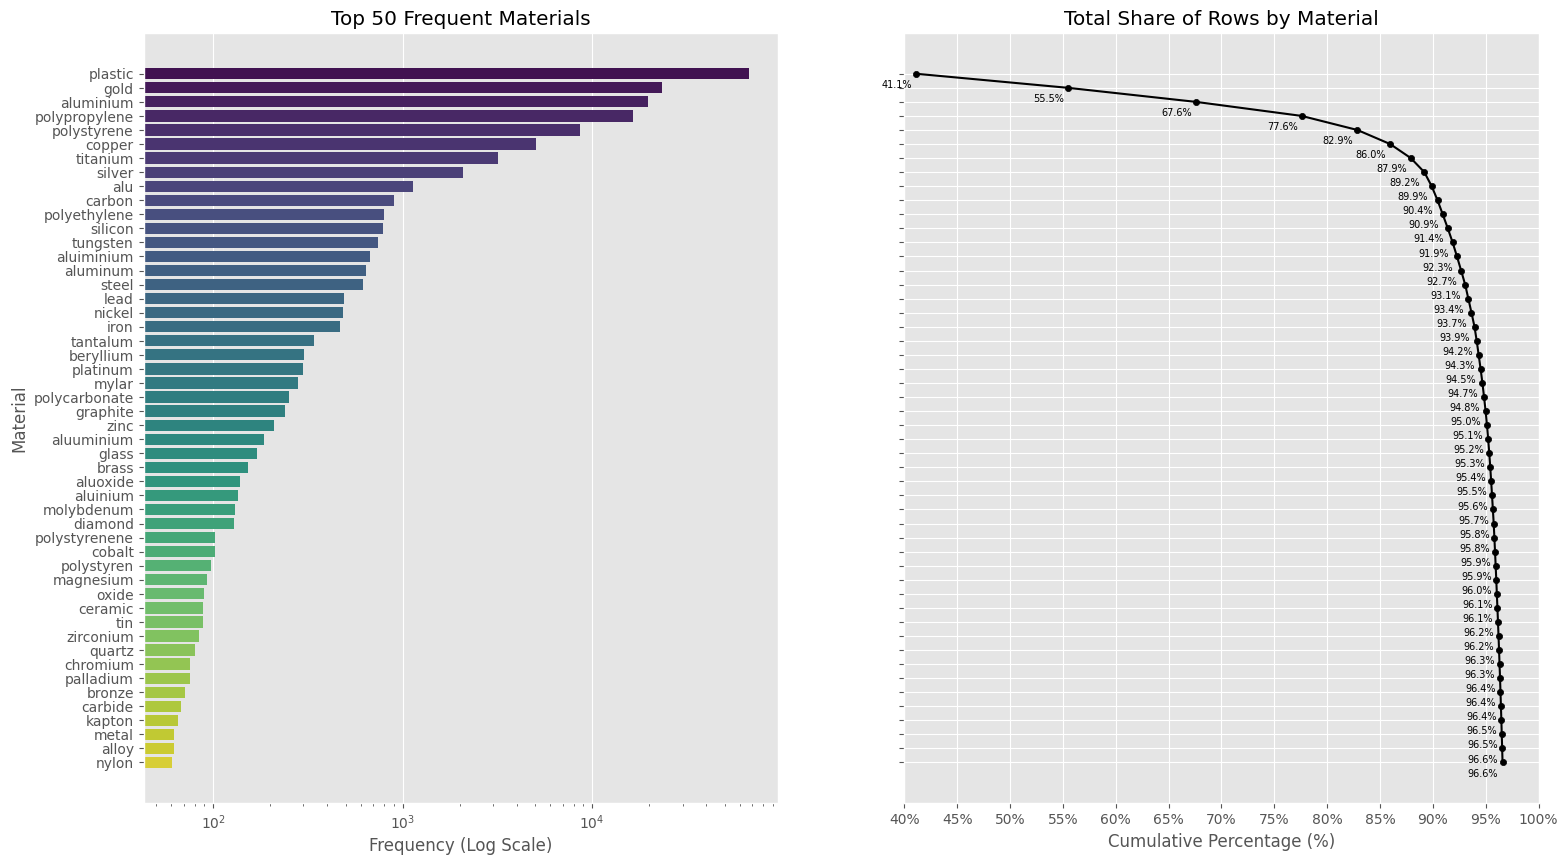

<Figure size 640x480 with 0 Axes>

In [4]:
# Count the occurrences of each 'target_material'
material_counts = df_remove_outliers_raw['target_material'].value_counts()

# Assuming 'material_counts' holds the value counts of 'target_material' from your DataFrame
top_25_materials = material_counts.head(50)  # Get the top 50 materials for better illustration

# Create a DataFrame from the top 25 materials for easier plotting
top_25_df = pd.DataFrame(top_25_materials).reset_index()
top_25_df.columns = ['target_material', 'count']

# Calculate cumulative percentage
total_rows = df_synthetic.shape[0]  # Total number of rows in the original DataFrame
top_25_df['cumulative_percent'] = top_25_df['count'].cumsum() / total_rows * 100

# Initialize the matplotlib figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 10), sharey=True)  # Share y-axis across subplots

# Left subplot for frequency
sns.barplot(x='count', y='target_material', data=top_25_df, ax=axes[0], hue='target_material',palette='viridis')
axes[0].set_xscale('log')
axes[0].set_xlabel('Frequency (Log Scale)')
axes[0].set_ylabel('Material')
axes[0].set_title('Top 50 Frequent Materials')

# Right subplot for cumulative percentage
sns.lineplot(x='cumulative_percent', y='target_material', data=top_25_df, ax=axes[1],color='black')
axes[1].set_xlabel('Cumulative Percentage (%)')
axes[1].set_title('Total Share of Rows by Material')

# Set x-axis to have a tick every 5 percent
axes[1].xaxis.set_major_locator(ticker.MultipleLocator(5))

# Optionally, you can format the ticks to show them as percentages
axes[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))

# If you want to limit the x-axis to show up to 100% only
axes[1].set_xlim(40, 100)

# Annotate each point on the line plot
for index, row in top_25_df.iterrows():
    axes[1].annotate(f"{row['cumulative_percent']:.1f}%", 
                     (row['cumulative_percent'], row['target_material']), 
                     textcoords="offset points", 
                     xytext=(-14,-10), 
                     ha='center', 
                     color='black', 
                     size=7,
    )
# Plotting the points as black dots
axes[1].scatter(top_25_df['cumulative_percent'], top_25_df['target_material'], color='black', s=20)  # s is the size of the dot

plt.show()

# Improve layout
plt.tight_layout()

# Save the figure
plt.savefig('./images/top_50_materials_comparison.jpg', dpi=300)
# Display the plot
plt.show()

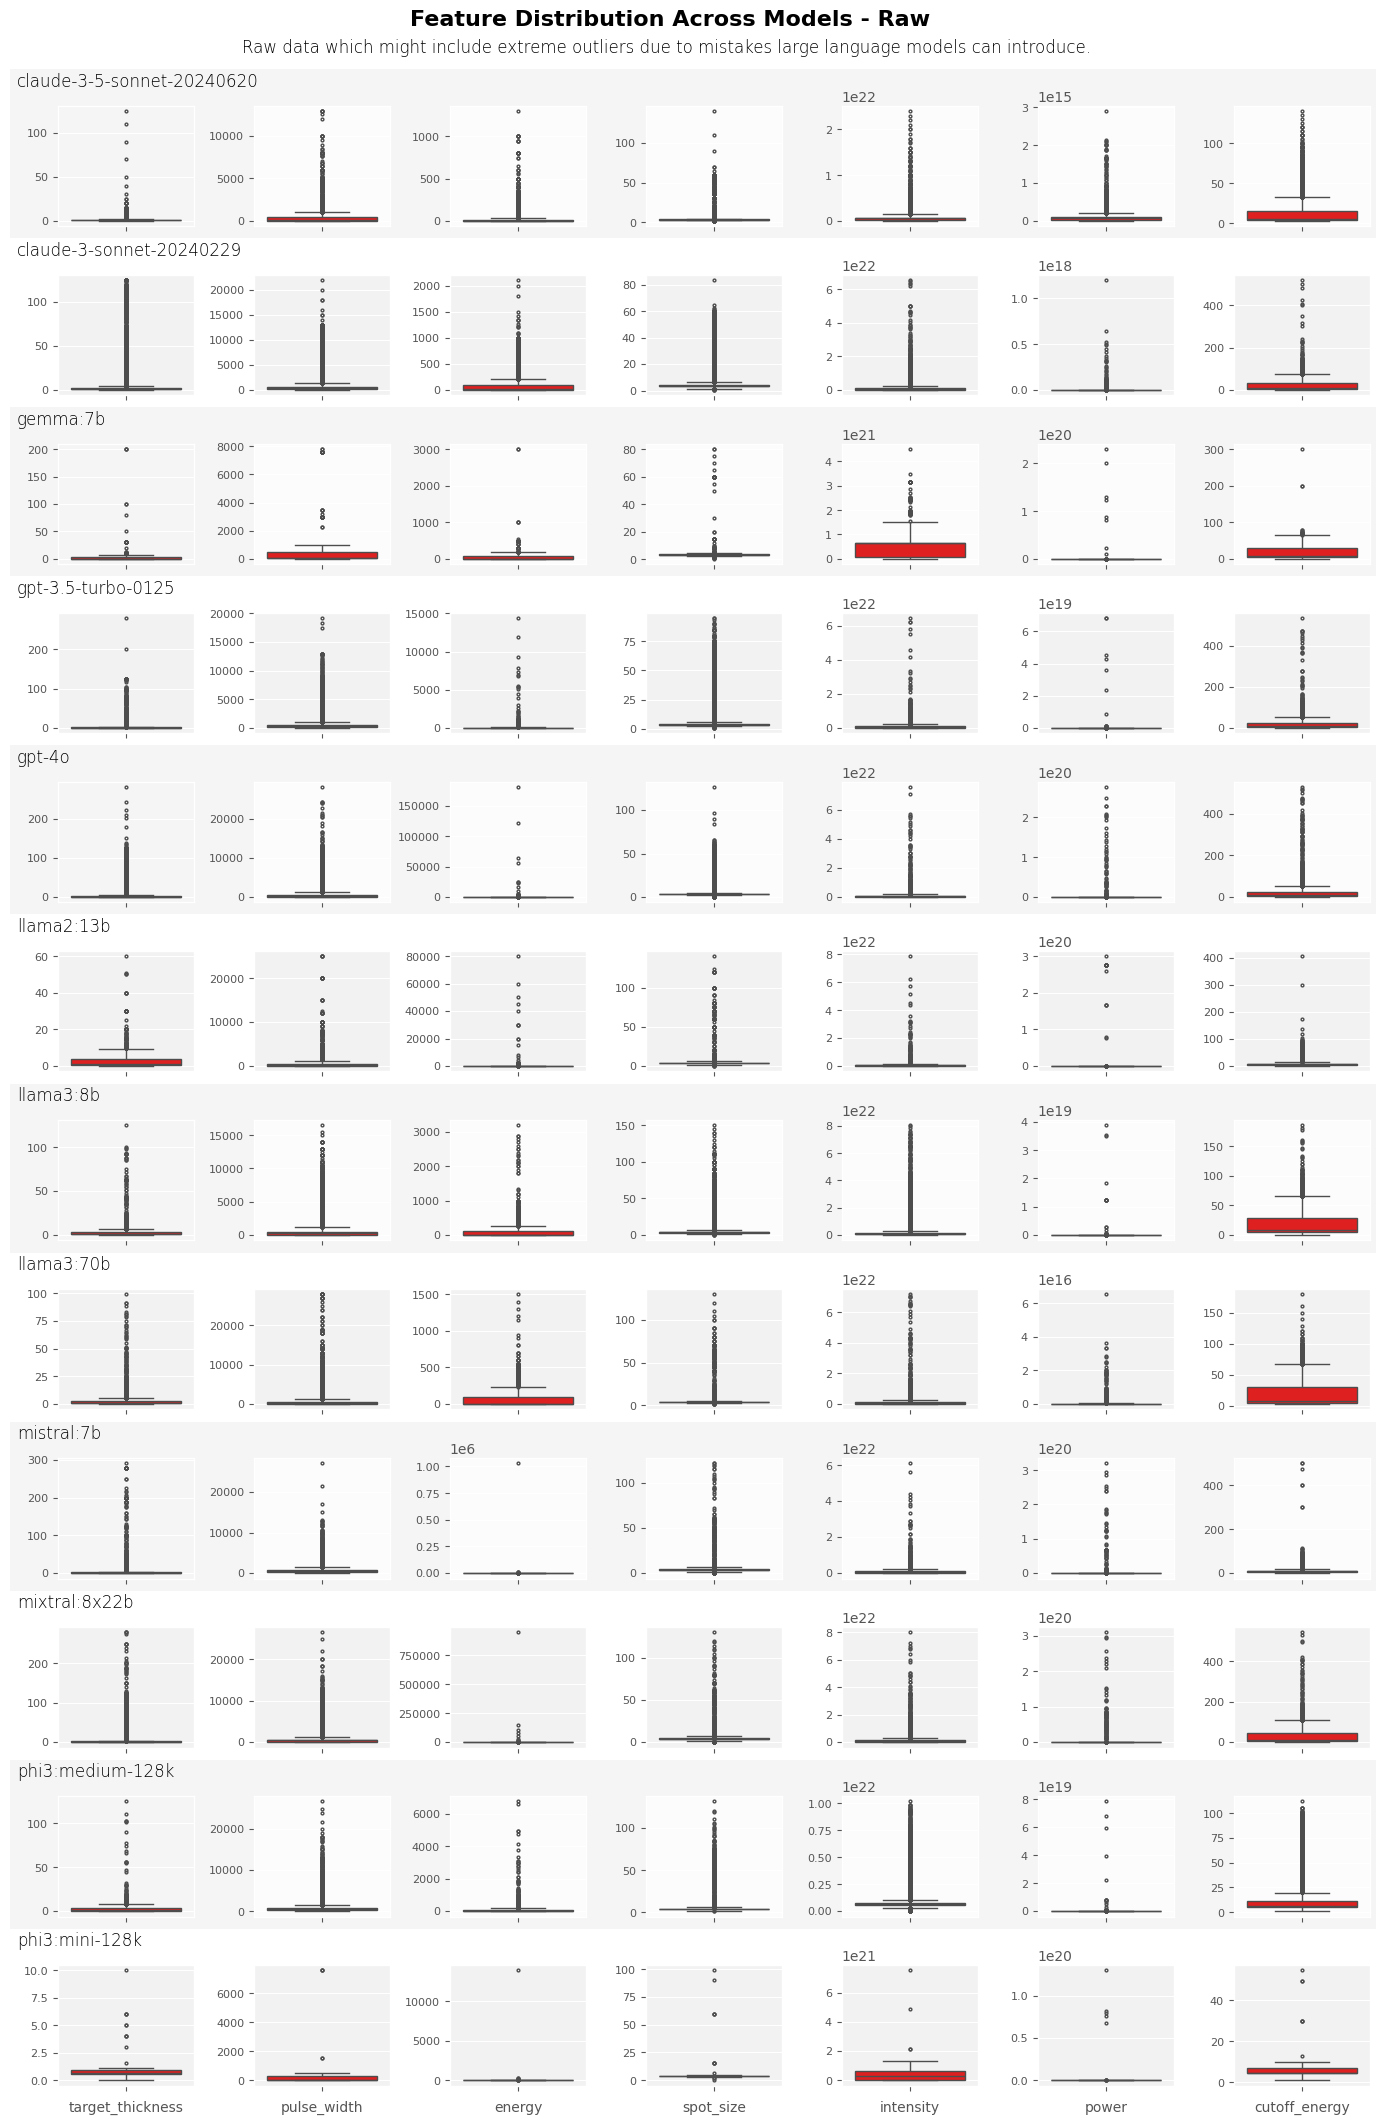

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

num_models = len(df_remove_outliers_raw['model'].unique())
num_features = len(numeric_features)

# Calculate the optimal figure size
fig_width = min(20, 2.5 * num_features)  # Cap the width at 20 inches
fig_height = min(30, 2 * num_models)  # Cap the height at 30 inches

# Initialize the matplotlib figure with subplots
fig, axes = plt.subplots(num_models, num_features, figsize=(fig_width, fig_height))

# If there's only one model, wrap axes in a list to make it 2D
if num_models == 1:
    axes = np.array([axes])

for i, model_name in enumerate(df_remove_outliers_raw['model'].unique()):
    # Filter the DataFrame for the specific model
    model_df = df_remove_outliers_raw[df_remove_outliers_raw['model'] == model_name].copy()

    for j, feature in enumerate(numeric_features):
        # Create a boxplot for the numeric features of this specific model
        sns.boxplot(data=model_df, y=feature, ax=axes[i, j], orient='v', color='red', fliersize=2)
        
        # Set the xlabel on each subplot
        axes[i, j].set_xlabel('')
        
        # Only set the feature name for the bottom row
        if i == num_models - 1:
            axes[i, j].set_xlabel(feature, fontsize=10, fontweight='normal')
        
        # Remove y-label for all subplots
        axes[i, j].set_ylabel('')

        # Rotate x-axis labels for better readability
        axes[i, j].tick_params(axis='x', rotation=45, labelsize=8)
        axes[i, j].tick_params(axis='y', labelsize=8)

        if i % 2 != 0:
            axes[i, j].patch.set_facecolor((0.95, 0.95, 0.95))  # Light grey color
        else:
            axes[i, j].patch.set_facecolor((0.99, 0.99, 0.99))  # Light grey color

    # Add model name to the top left corner of each row
    axes[i, 0].text(-0.3, 1.125, model_name, transform=axes[i, 0].transAxes, 
                    fontsize=12, fontweight='light', ha='left', va='bottom')

    # Extend the shaded background to include the model name area for shaded rows
    if i % 2 == 0:
        axes[i, 0].add_patch(plt.Rectangle((-0.35, -0.1), 10, 1.4, 
                                           fill=True, transform=axes[i, 0].transAxes, 
                                           facecolor=(0.96, 0.96, 0.96), clip_on=False, zorder=0))

# Adjust the layout and spacing
plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.435, top=0.935, left=0.15)

# Add a main title
fig.suptitle('Feature Distribution Across Models - Raw', fontsize=16, fontweight='bold', y=0.975)
fig.text(s='Raw data which might include extreme outliers due to mistakes large language models can introduce.',y=0.957,x=0.255,fontsize=12, fontweight='light')

# Save the figure with high resolution
plt.savefig('./images/boxplot_outliers_models_raw.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

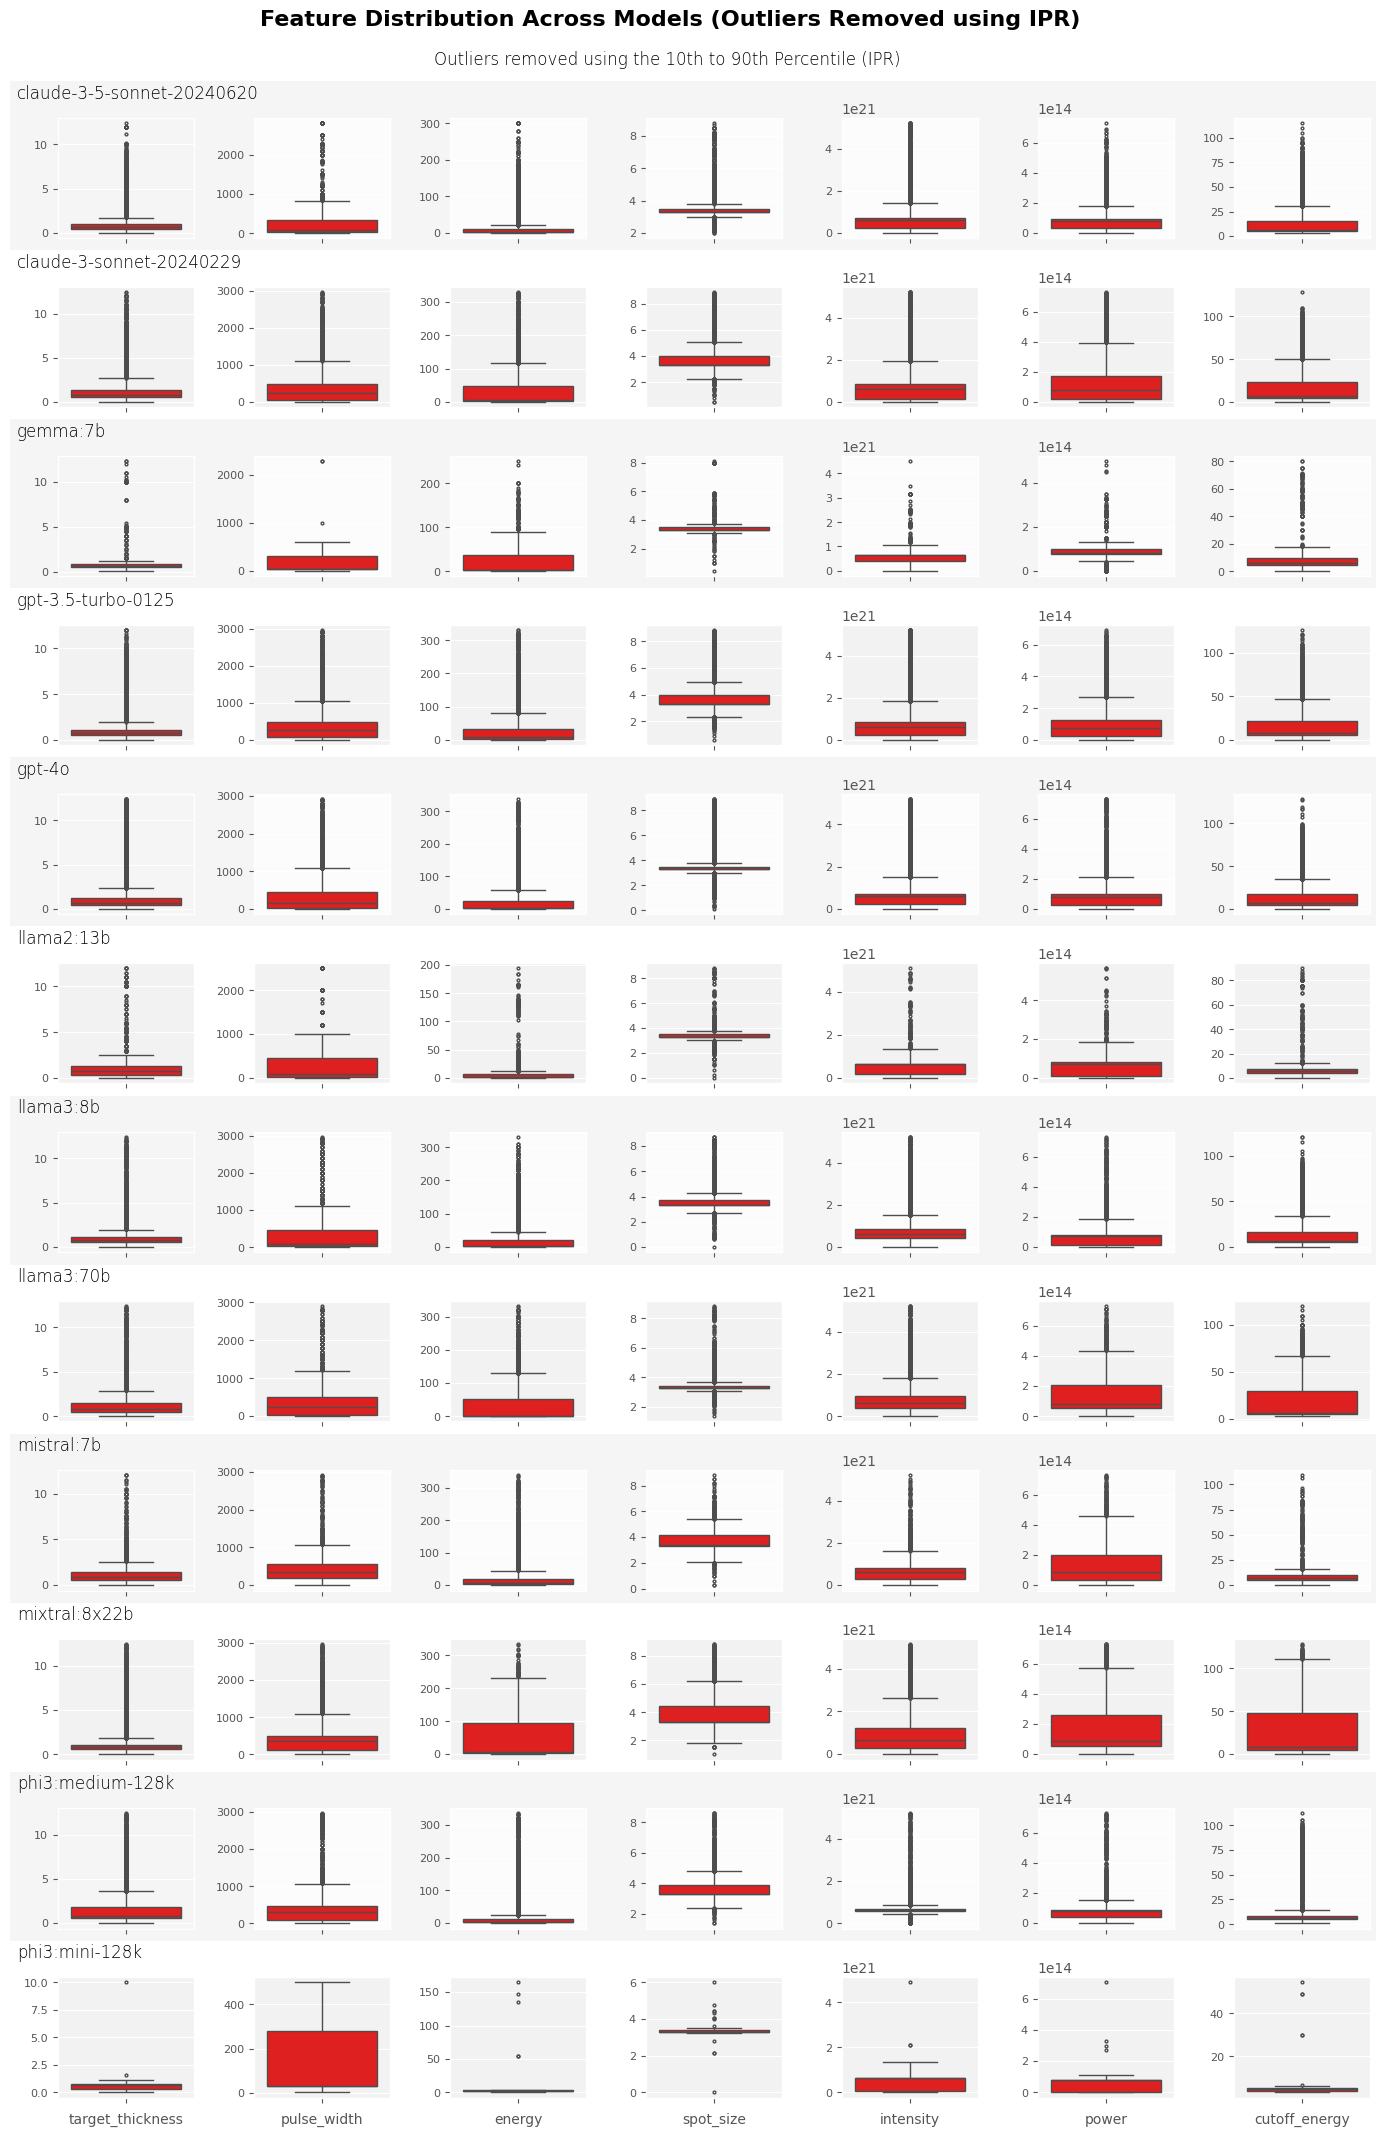

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# USING THE IPR DATAFRAME
num_models = len(df_remove_outliers_ipr['model'].unique())
num_features = len(numeric_features)

# Calculate the optimal figure size
fig_width = min(20, 2.5 * num_features)  # Cap the width at 20 inches
fig_height = min(30, 2 * num_models)  # Cap the height at 30 inches

# Initialize the matplotlib figure with subplots
fig, axes = plt.subplots(num_models, num_features, figsize=(fig_width, fig_height))

# If there's only one model, wrap axes in a list to make it 2D
if num_models == 1:
    axes = np.array([axes])

for i, model_name in enumerate(df_remove_outliers_ipr['model'].unique()):
    # Filter the DataFrame for the specific model
    model_df = df_remove_outliers_ipr[df_remove_outliers_ipr['model'] == model_name].copy()

    for j, feature in enumerate(numeric_features):
        # Create a boxplot for the numeric features of this specific model
        sns.boxplot(data=model_df, y=feature, ax=axes[i, j], orient='v', color='red', fliersize=2)
        
        # Set the xlabel on each subplot
        axes[i, j].set_xlabel('')
        
        # Only set the feature name for the bottom row
        if i == num_models - 1:
            axes[i, j].set_xlabel(feature, fontsize=10, fontweight='normal')
        
        # Remove y-label for all subplots
        axes[i, j].set_ylabel('')

        # Rotate x-axis labels for better readability
        axes[i, j].tick_params(axis='x', rotation=45, labelsize=8)
        axes[i, j].tick_params(axis='y', labelsize=8)

        if i % 2 != 0:
            axes[i, j].patch.set_facecolor((0.95, 0.95, 0.95))  # Light grey color
        else:
            axes[i, j].patch.set_facecolor((0.99, 0.99, 0.99))  # Very light grey color

    # Add model name to the top left corner of each row
    axes[i, 0].text(-0.3, 1.125, model_name, transform=axes[i, 0].transAxes, 
                    fontsize=12, fontweight='light', ha='left', va='bottom')

    # Extend the shaded background to include the model name area for shaded rows
    if i % 2 == 0:
        axes[i, 0].add_patch(plt.Rectangle((-0.35, -0.1), 10, 1.4, 
                                           fill=True, transform=axes[i, 0].transAxes, 
                                           facecolor=(0.96, 0.96, 0.96), clip_on=False, zorder=0))

# Adjust the layout and spacing
plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.435, top=0.935, left=0.15)

# Add a main title
fig.suptitle('Feature Distribution Across Models - Cleaned with IPR', fontsize=16, fontweight='bold', y=0.975)
fig.text(s='Outliers removed using the 10th to 90th Percentile (IPR)',y=0.957,x=0.365,fontsize=12, fontweight='light')

# Add a main title
fig.suptitle('Feature Distribution Across Models (Outliers Removed using IPR)', fontsize=16, fontweight='bold', y=0.98)

# Save the figure with high resolution
plt.savefig('./images/boxplot_outliers_models_rm_outliers_ipr', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

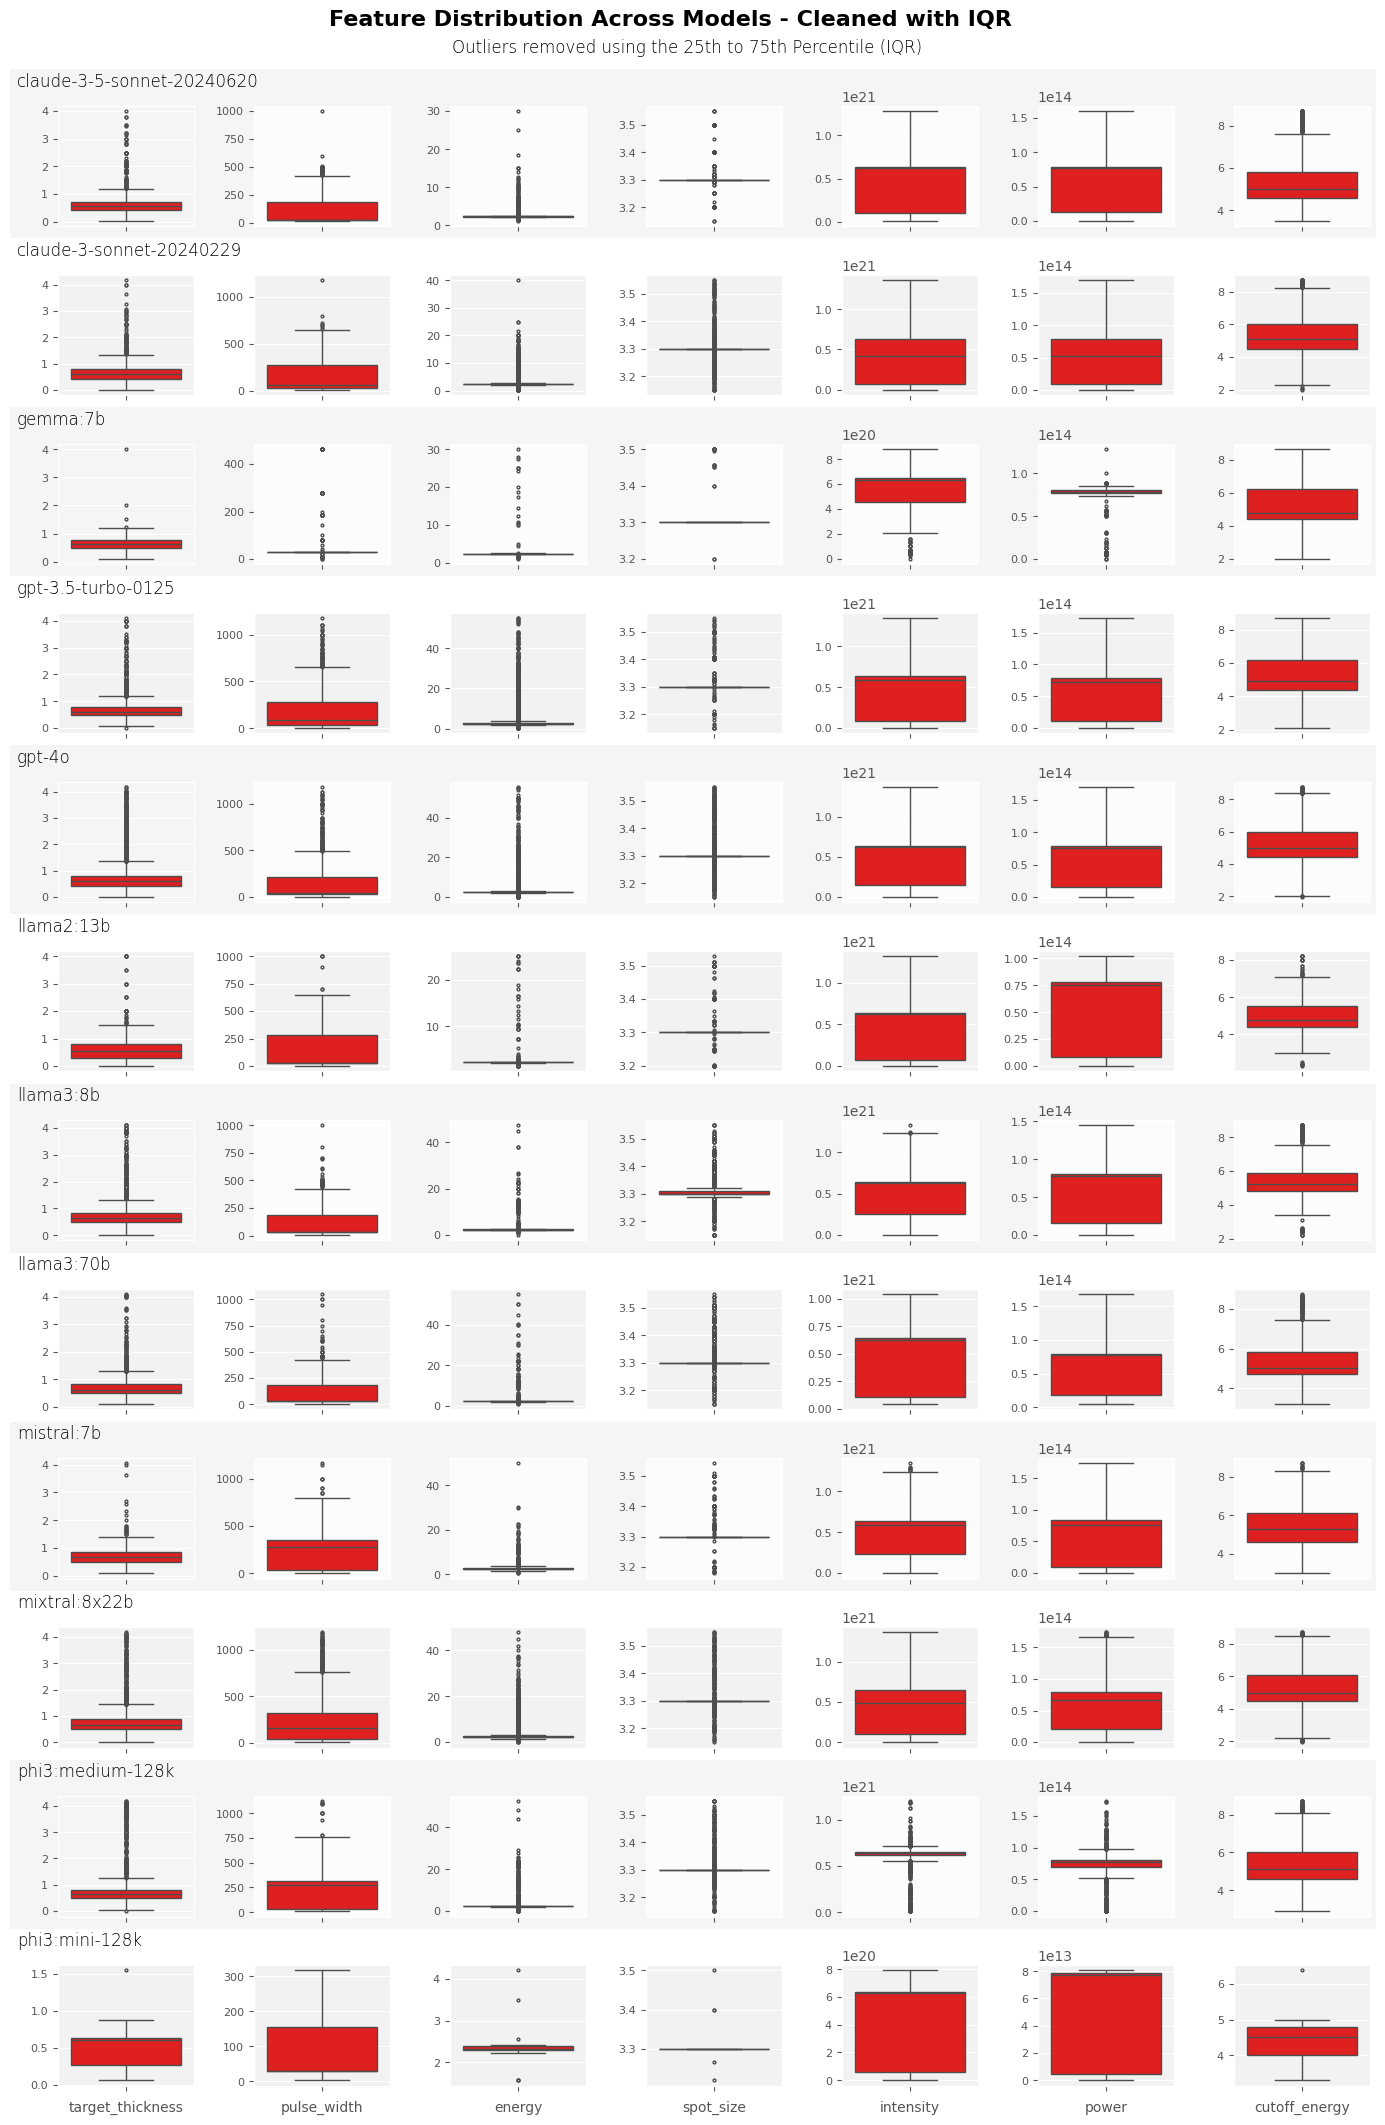

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### USING THE IQR DATAFRAME

num_models = len(df_remove_outliers_iqr['model'].unique())
num_features = len(numeric_features)

# Calculate the optimal figure size
fig_width = min(20, 2.5 * num_features)  # Cap the width at 20 inches
fig_height = min(30, 2 * num_models)  # Cap the height at 30 inches

# Initialize the matplotlib figure with subplots
fig, axes = plt.subplots(num_models, num_features, figsize=(fig_width, fig_height))

# If there's only one model, wrap axes in a list to make it 2D
if num_models == 1:
    axes = np.array([axes])

for i, model_name in enumerate(df_remove_outliers_iqr['model'].unique()):
    # Filter the DataFrame for the specific model
    model_df = df_remove_outliers_iqr[df_remove_outliers_iqr['model'] == model_name].copy()

    for j, feature in enumerate(numeric_features):
        # Create a boxplot for the numeric features of this specific model
        sns.boxplot(data=model_df, y=feature, ax=axes[i, j], orient='v', color='red', fliersize=2)
        
        # Set the xlabel on each subplot
        axes[i, j].set_xlabel('')
        
        # Only set the feature name for the bottom row
        if i == num_models - 1:
            axes[i, j].set_xlabel(feature, fontsize=10, fontweight='normal')
        
        # Remove y-label for all subplots
        axes[i, j].set_ylabel('')

        # Rotate x-axis labels for better readability
        axes[i, j].tick_params(axis='x', rotation=45, labelsize=8)
        axes[i, j].tick_params(axis='y', labelsize=8)

        if i % 2 != 0:
            axes[i, j].patch.set_facecolor((0.95, 0.95, 0.95))  # Light grey color
        else:
            axes[i, j].patch.set_facecolor((0.99, 0.99, 0.99))  # Very light grey color

    # Add model name to the top left corner of each row
    axes[i, 0].text(-0.3, 1.125, model_name, transform=axes[i, 0].transAxes, 
                    fontsize=12, fontweight='light', ha='left', va='bottom')

    # Extend the shaded background to include the model name area for shaded rows
    if i % 2 == 0:
        axes[i, 0].add_patch(plt.Rectangle((-0.35, -0.1), 10, 1.4, 
                                           fill=True, transform=axes[i, 0].transAxes, 
                                           facecolor=(0.96, 0.96, 0.96), clip_on=False, zorder=0))

# Adjust the layout and spacing
plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.435, top=0.935, left=0.15)

# Add a main title
fig.suptitle('Feature Distribution Across Models - Cleaned with IQR', fontsize=16, fontweight='bold', y=0.975)
fig.text(s='Outliers removed using the 25th to 75th Percentile (IQR)',y=0.957,x=0.375,fontsize=12, fontweight='light')

# Save the figure with high resolution
plt.savefig('./images/boxplot_outliers_models_rm_outliers_iqr.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

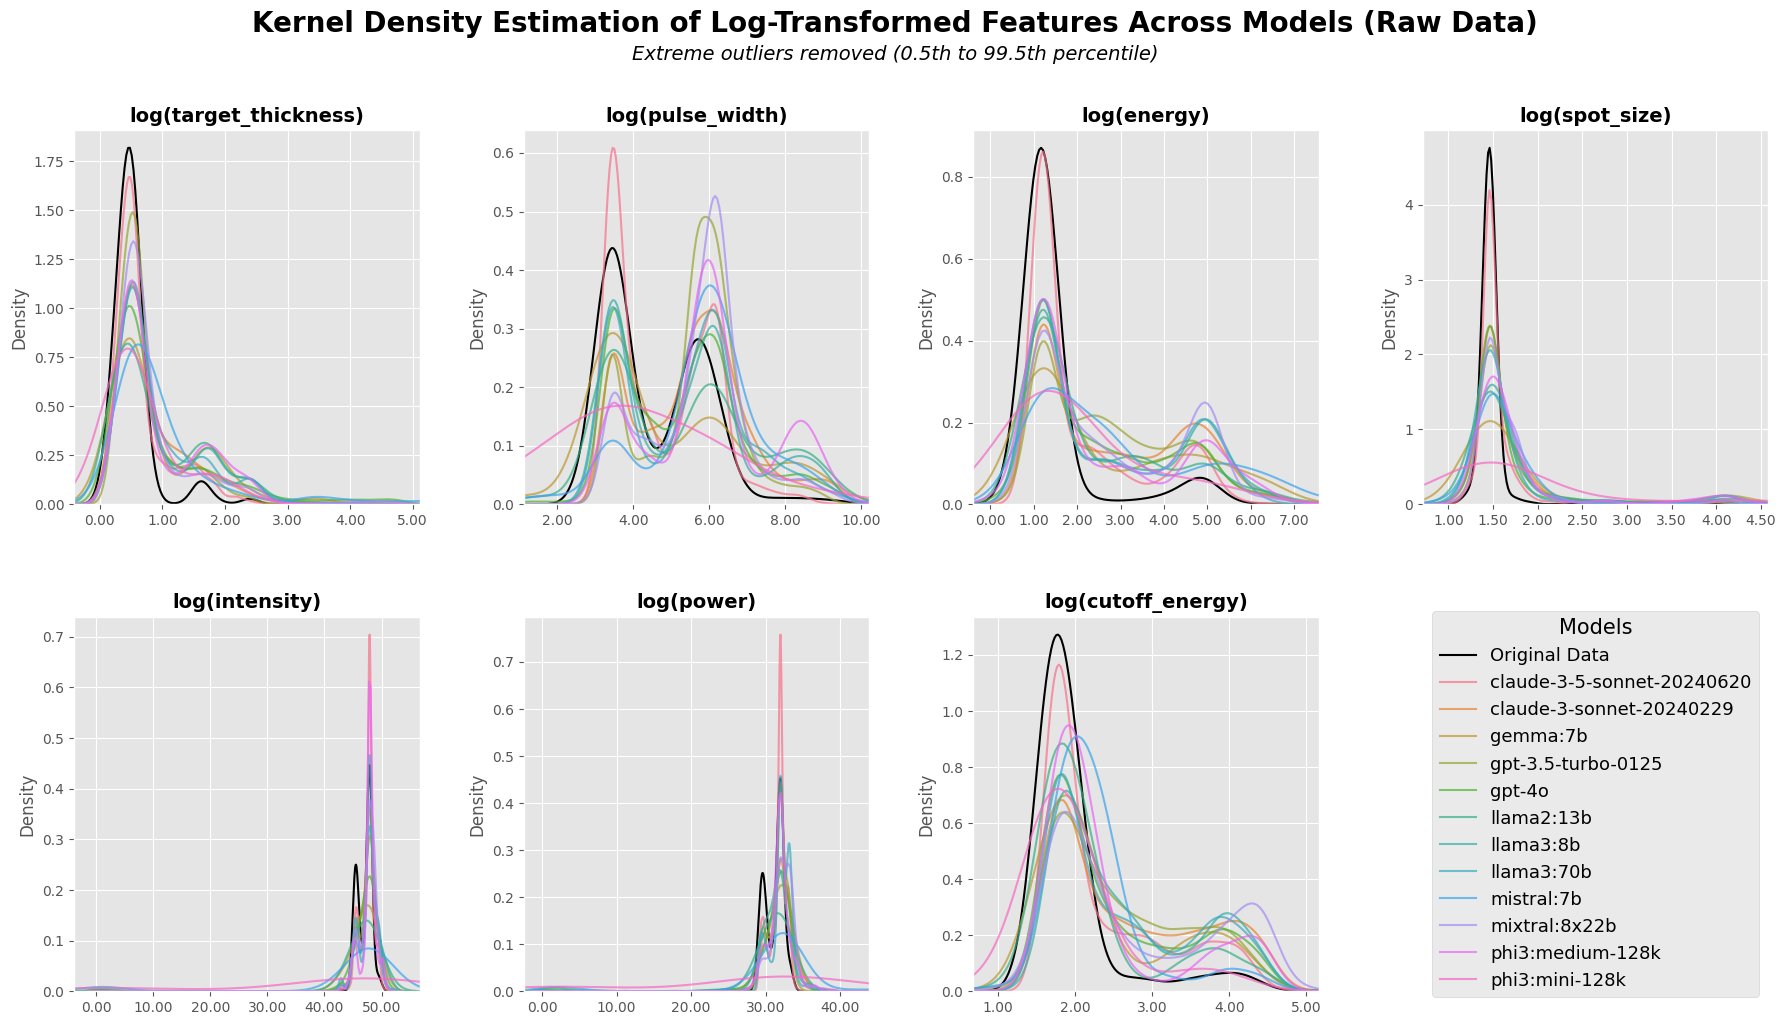

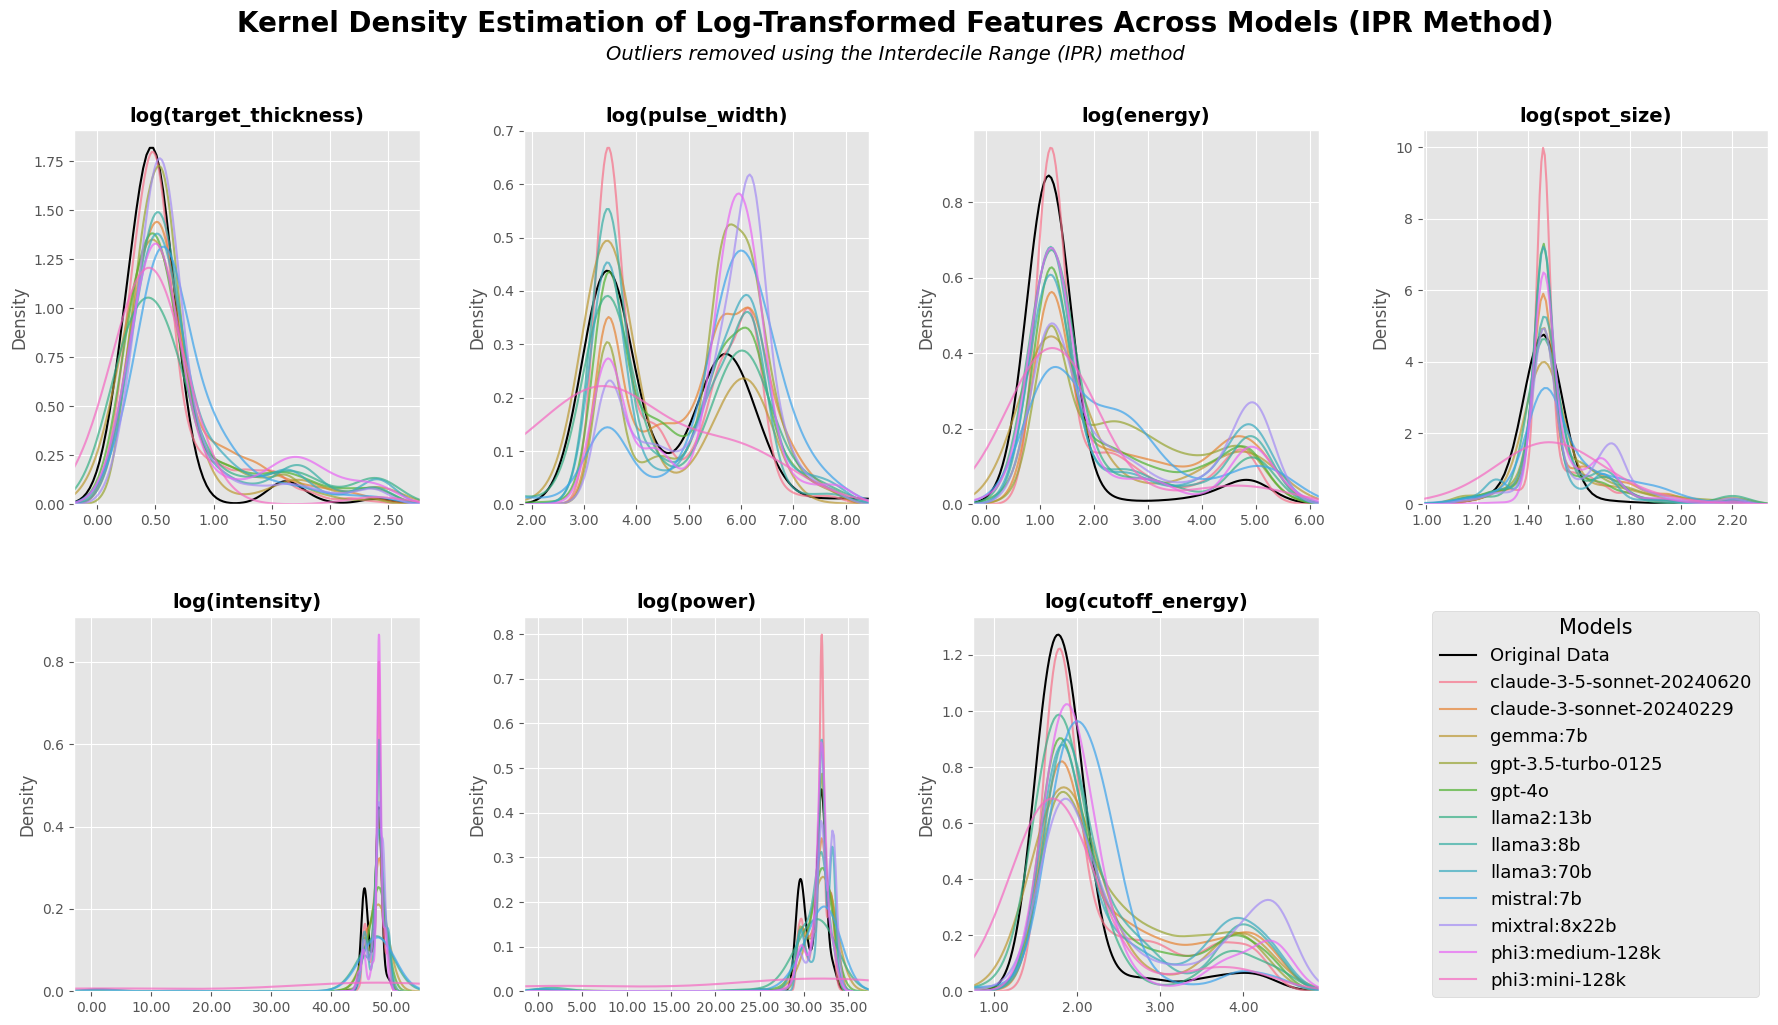

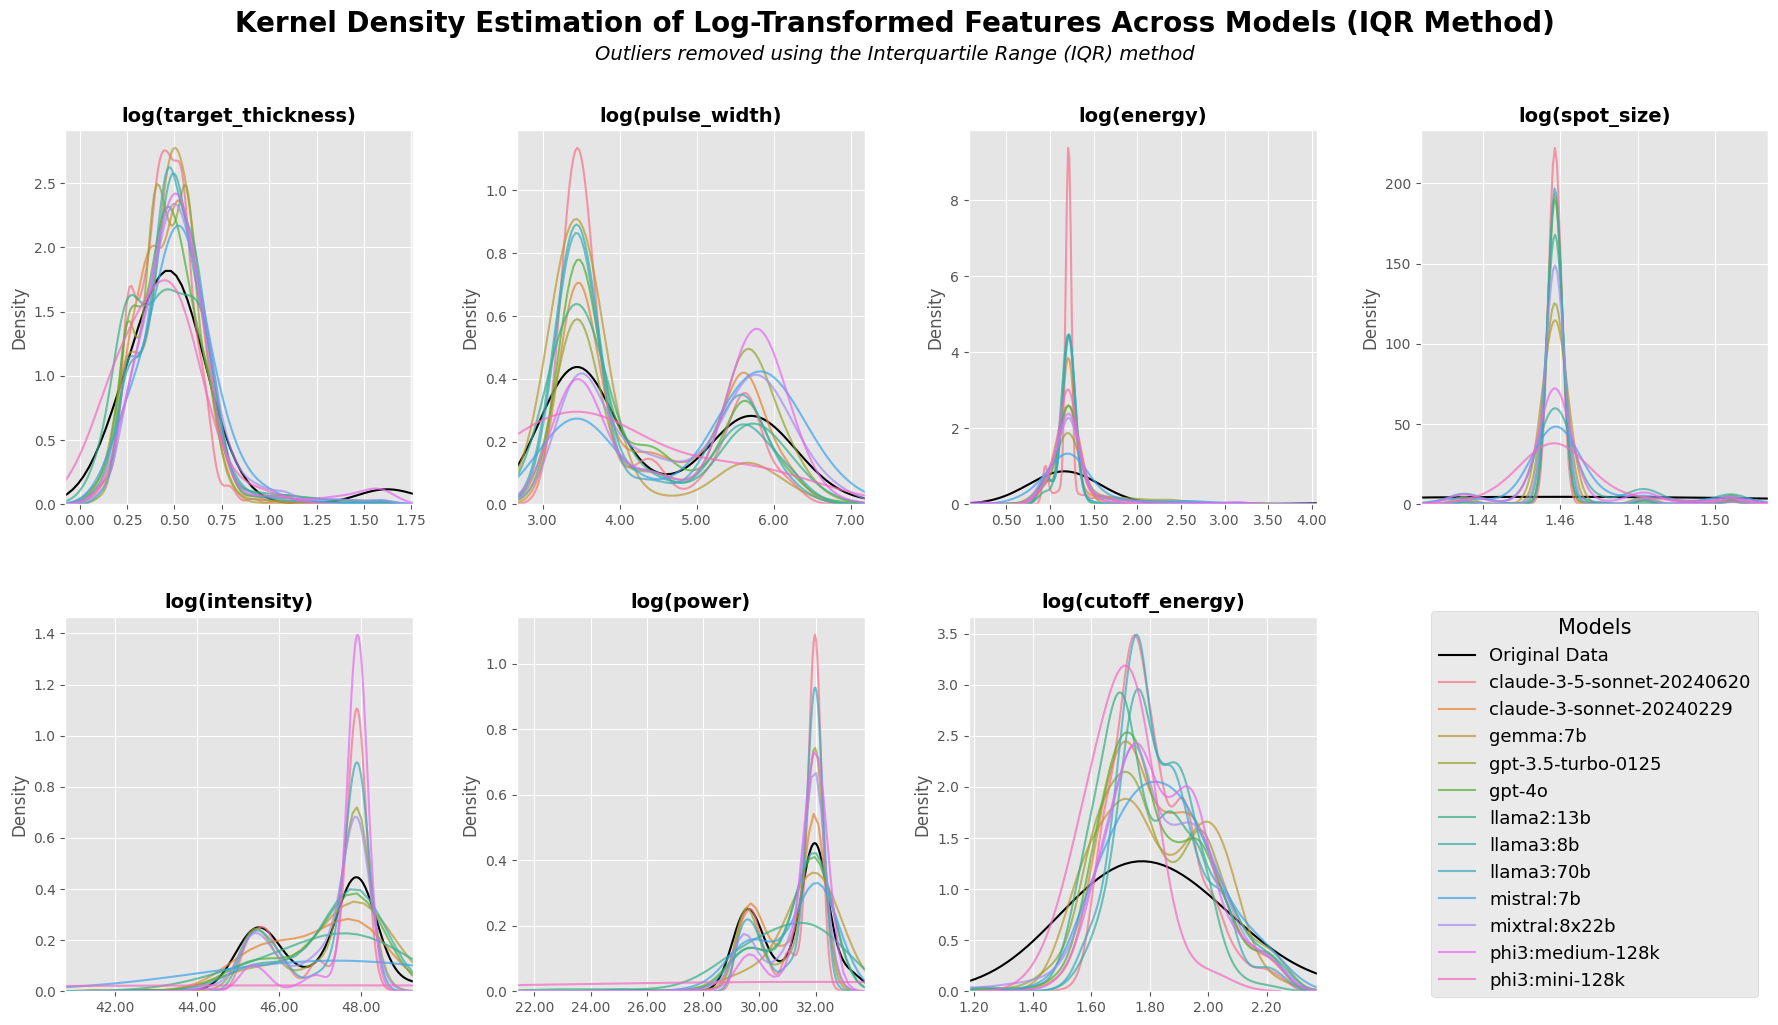

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def create_kde_plot(data, title, subtitle):
    fig, axes = plt.subplots(2, 4, figsize=(18, 10))
    axes = axes.flatten()

    synthetic_models = [model for model in data['model'].unique() if model != 'original data']
    color_palette = sns.color_palette("husl", n_colors=len(synthetic_models))

    for i, feature in enumerate(numeric_features):
        ax = axes[i]
        
        # Determine the x-axis range
        x_min = max(0, data[feature].quantile(0.0025))  # Use 1st percentile, but never go below 0
        x_max = data[feature].quantile(0.9975)  # Use 99th percentile to exclude extreme outliers
        x_range = x_max - x_min
        x_padding = x_range * 0.1  # Add 10% padding on each side
        
        original_data = data[data['model'] == 'original data']
        if not original_data.empty:
            sns.kdeplot(data=original_data, x=feature, ax=ax, color='black', alpha=1, label='Original Data', bw_adjust=1.5)
        
        for j, model in enumerate(synthetic_models):
            model_data = data[data['model'] == model]

            if model_data[feature].nunique() == 1:
                print(f"  Skipping plot for {model} - all values are the same")
                continue
            
            sns.kdeplot(data=model_data, x=feature, ax=ax, color=color_palette[j], alpha=0.7, label=model, bw_adjust=1.5)
        
        ax.set_title(f"log({feature})", fontsize=14, fontweight='bold')
        ax.set_xlabel('')
        ax.set_ylabel('Density', fontsize=12)
        ax.tick_params(axis='both', which='major', labelsize=10)
        ax.set_xlim(x_min - x_padding, x_max + x_padding)
        ax.legend().remove()
        
        # Remove scientific notation from x-axis
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))

    handles, labels = axes[0].get_legend_handles_labels()
    axes[-1].legend(handles, labels, title='Models', title_fontsize='15', fontsize='13', loc='center', bbox_to_anchor=(0.5, 0.5), bbox_transform=axes[-1].transAxes)
    axes[-1].axis('off')

    plt.tight_layout()
    fig.suptitle(title, fontsize=20, fontweight='bold', y=1.02)
    fig.text(0.5, 0.97, subtitle, ha='center', fontsize=14, fontstyle='italic')
    plt.subplots_adjust(top=0.9, hspace=0.3, wspace=0.3)

    return fig

df_original_log = df_original.copy()
df_remove_outliers_raw_log = df_remove_outliers_raw.copy()
df_remove_outliers_ipr_log = df_remove_outliers_ipr.copy()
df_remove_outliers_iqr_log = df_remove_outliers_iqr.copy()

# Add 'model' column to df_original and select only numeric features
df_original_log['model'] = 'original data'
df_original_log = df_original_log[['model'] + numeric_features]

# Log transform numeric features
for feature in numeric_features:
    df_original_log[feature]            = np.log1p(df_original_log[feature])
    df_remove_outliers_raw_log[feature] = np.log1p(df_remove_outliers_raw[feature])
    df_remove_outliers_ipr_log[feature] = np.log1p(df_remove_outliers_ipr_log[feature])
    df_remove_outliers_iqr_log[feature] = np.log1p(df_remove_outliers_iqr_log[feature])

# Add original data to cleaned dataframes
df_clean_raw_with_original = pd.concat([df_remove_outliers_raw_log, df_original_log], ignore_index=True)

# Create and save plots for raw data (without inf/NaN values), IQR-cleaned data, and IPR-cleaned data
raw_plot = create_kde_plot(df_clean_raw_with_original, 'Kernel Density Estimation of Log-Transformed Features Across Models (Raw Data)', 'Extreme outliers removed (0.5th to 99.5th percentile)')
raw_plot.savefig('./images/kde_features_across_models_raw_log.png', dpi=300, bbox_inches='tight')

# Add original data to IPR-cleaned dataframe
df_clean_ipr_with_original = pd.concat([df_remove_outliers_ipr_log, df_original_log], ignore_index=True)

ipr_plot = create_kde_plot(df_clean_ipr_with_original, 'Kernel Density Estimation of Log-Transformed Features Across Models (IPR Method)', 'Outliers removed using the Interdecile Range (IPR) method')
ipr_plot.savefig('./images/kde_features_across_models_ipr_log.png', dpi=300, bbox_inches='tight')

# Add original data to IQR-cleaned dataframe
df_clean_iqr_with_original = pd.concat([df_remove_outliers_iqr_log, df_original_log], ignore_index=True)

iqr_plot = create_kde_plot(df_clean_iqr_with_original, 'Kernel Density Estimation of Log-Transformed Features Across Models (IQR Method)', 'Outliers removed using the Interquartile Range (IQR) method')
iqr_plot.savefig('./images/kde_features_across_models_iqr_log.png', dpi=300, bbox_inches='tight')

plt.show()

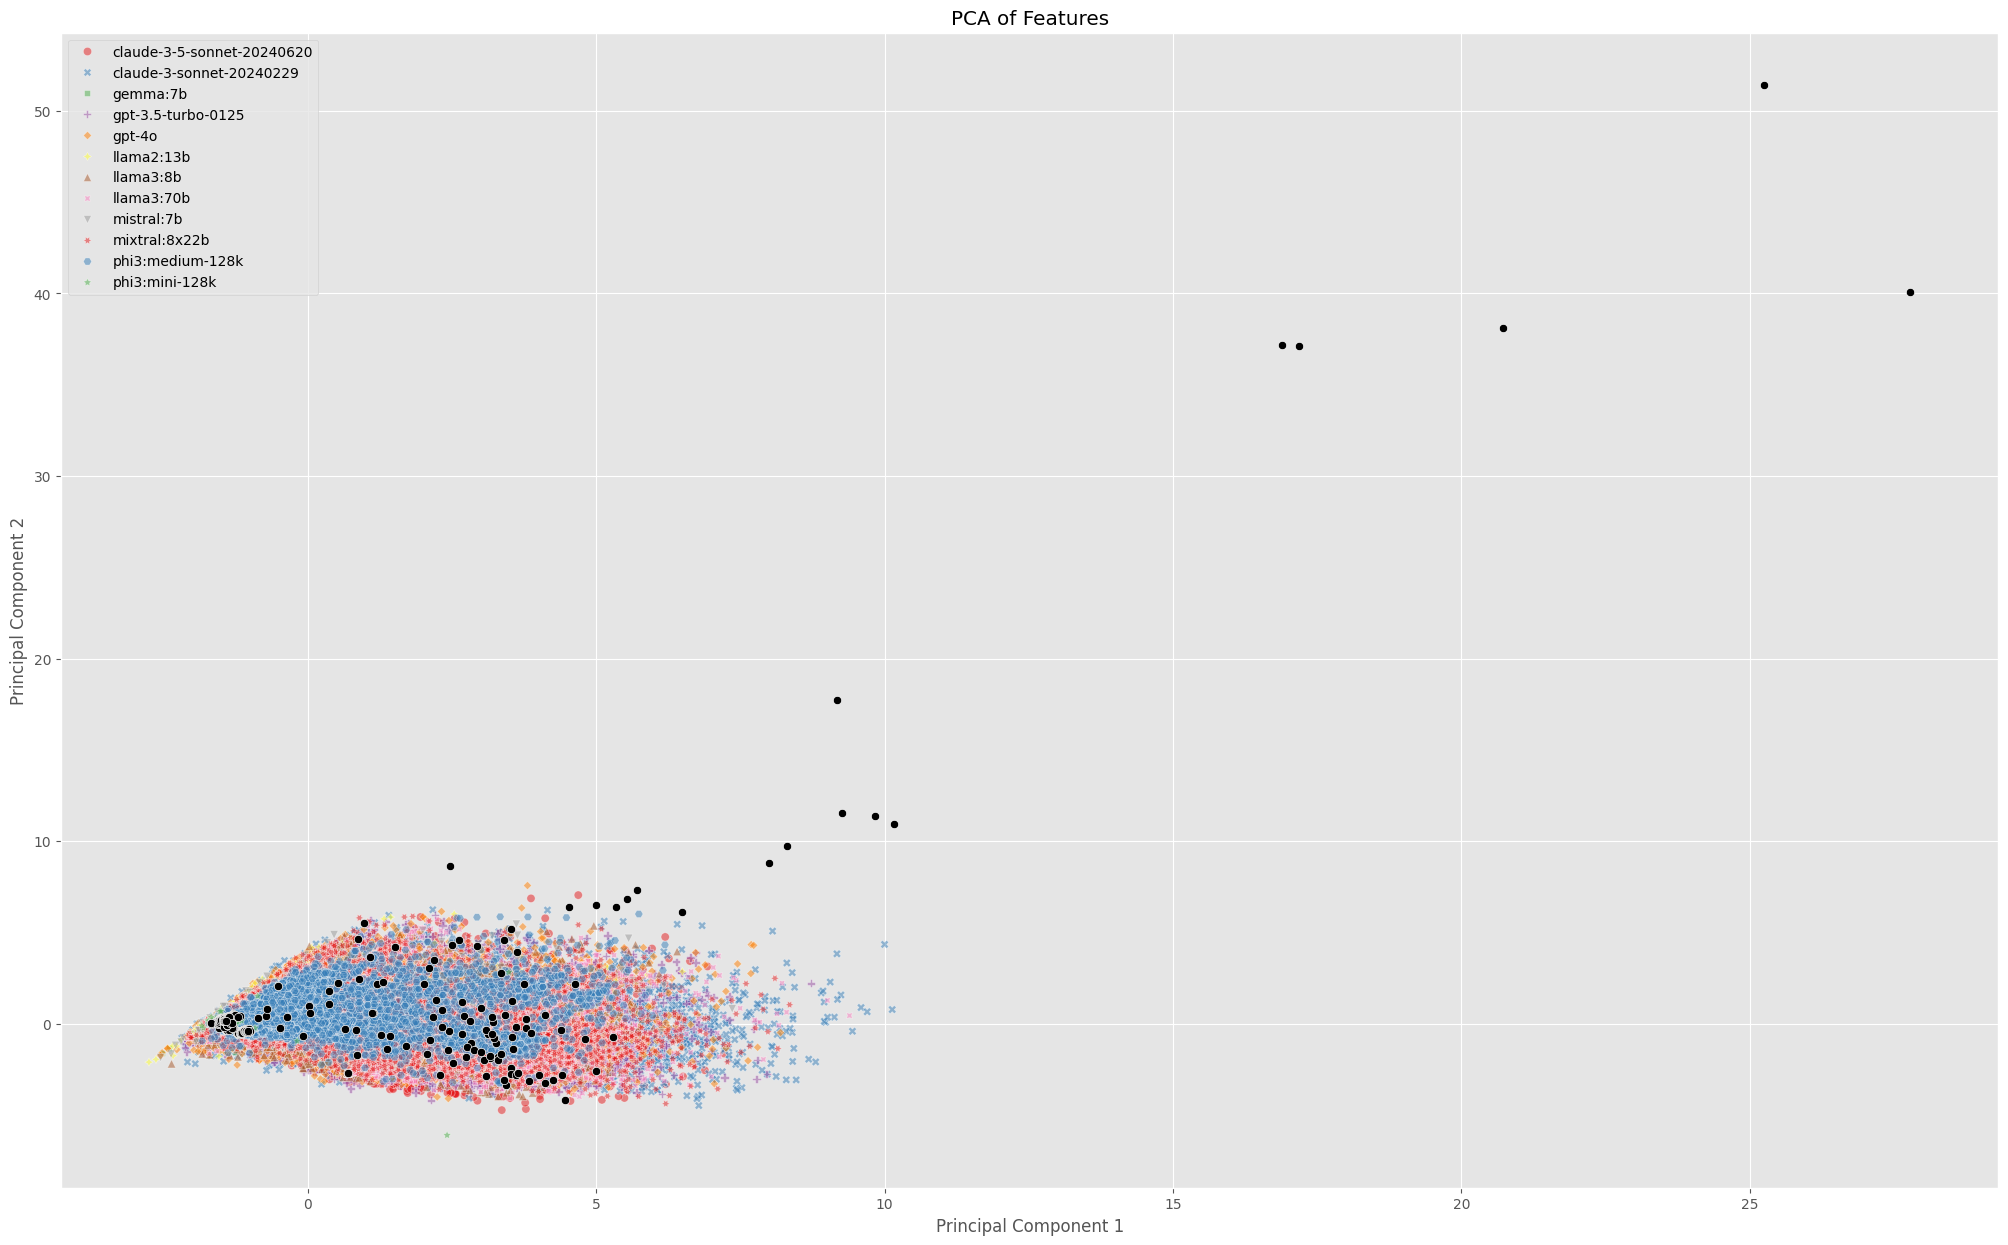

In [9]:
# Assuming df_remove_outliers and df_original are already loaded

# Selecting numerical features for PCA
features = ['target_thickness', 'pulse_width', 'energy', 'spot_size', 'intensity', 'power', 'cutoff_energy']

# Ensure df_original has all columns from df_remove_outliers
missing_cols = set(df_remove_outliers_ipr.columns) - set(df_original.columns)
for col in missing_cols:
    df_original[col] = np.nan

# Add 'source' column
df_remove_outliers_ipr['source'] = 'synthetic'
df_original['source'] = 'original'

# Drop NaN values only from the synthetic data
df_remove_outliers_clean = df_remove_outliers_ipr.copy()
df_remove_outliers_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
df_remove_outliers_clean.dropna(subset=features, inplace=True)

# Combine the cleaned synthetic DataFrame with the original DataFrame
combined_df = pd.concat([df_remove_outliers_clean, df_original], ignore_index=True)

# Now proceed with PCA on the combined DataFrame
X = combined_df[features].copy()  # Create a copy to avoid SettingWithCopyWarning

# Standardizing the features
X_scaled = StandardScaler().fit_transform(X)

# Proceed with PCA
pca = PCA(n_components=2)  # Example: reducing to 2 principal components
principal_components = pca.fit_transform(X_scaled)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])

# Adding the source and model information back to the PCA DataFrame
pca_df = pd.concat([pca_df, combined_df.reset_index(drop=True)[['source', 'model']]], axis=1)

# Handle NaNs in the 'model' column for original data
pca_df['model'].fillna('original', inplace=True)

# Separate the synthetic and original data points
synthetic_points = pca_df[pca_df['source'] == 'synthetic']
original_points = pca_df[pca_df['source'] == 'original']

# Plotting the PCA result
plt.figure(figsize=(25, 15))

# Plot synthetic points first
sns.scatterplot(data=synthetic_points, x='Principal Component 1', y='Principal Component 2', hue='model', style='model', palette='Set1', alpha=0.5, legend=True)

# Plot original points on top in black
sns.scatterplot(data=original_points, x='Principal Component 1', y='Principal Component 2', color='black')

plt.title('PCA of Features')
plt.show()


In [10]:
# Assuming df_remove_outliers and df_original are already loaded

# Selecting numerical features for PCA
features = ['target_thickness', 'pulse_width', 'energy', 'spot_size', 'intensity', 'power', 'cutoff_energy']

# Ensure df_original has all columns from df_remove_outliers
missing_cols = set(df_remove_outliers.columns) - set(df_original.columns)
for col in missing_cols:
    df_original[col] = np.nan

# Add 'source' column
df_remove_outliers_ipr['source'] = 'synthetic'
df_original['source'] = 'original'

# Drop NaN values only from the synthetic data
df_remove_outliers_clean = df_remove_outliers_ipr.copy()
df_remove_outliers_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
df_remove_outliers_clean.dropna(subset=features, inplace=True)

# Combine the cleaned synthetic DataFrame with the original DataFrame
combined_df = pd.concat([df_remove_outliers_clean, df_original], ignore_index=True)

# Now proceed with PCA on the combined DataFrame
X = combined_df[features].copy()  # Create a copy to avoid SettingWithCopyWarning

# Standardizing the features
X_scaled = StandardScaler().fit_transform(X)

# Proceed with PCA
pca = PCA(n_components=2)  # Example: reducing to 2 principal components
principal_components = pca.fit_transform(X_scaled)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])

# Adding the source and model information back to the PCA DataFrame
pca_df = pd.concat([pca_df, combined_df_synthetic.reset_index(drop=True)[['source', 'model']]], axis=1)

# Handle NaNs in the 'model' column for original data
pca_df['model'].fillna('original', inplace=True)

# Separate the synthetic and original data points
synthetic_points = pca_df[pca_df['source'] == 'synthetic']
original_points = pca_df[pca_df['source'] == 'original']

# Plotting the PCA result
plt.figure(figsize=(25, 15))

for i, model_name in enumerate(df['model'].unique()):
    # Plot synthetic points first
    sns.scatterplot(data=synthetic_points[pca_df['model'] == model_name], x='Principal Component 1', y='Principal Component 2', hue='model', style='model', palette='Set1', alpha=0.5, legend=False)

    # Plot original points on top in black
    sns.scatterplot(data=original_points, x='Principal Component 1', y='Principal Component 2', color='black', alpha=0.5,)

    plt.title(f'PCA of Features - Original Dataset vs Synthetic Data (outliers removed)\n{model_name}')

    plt.savefig(f'./images/pca_original_vs_synth_{model_name}.jpg',dpi=300)
    plt.show()


NameError: name 'df_remove_outliers' is not defined

In [ ]:
# Assuming df_remove_outliers and df_original are already loaded

# Selecting numerical features for PCA
features = ['target_thickness', 'pulse_width', 'energy', 'spot_size', 'intensity', 'power', 'cutoff_energy']

# Ensure df_original has all columns from df_remove_outliers
missing_cols = set(df_remove_outliers_ipr.columns) - set(df_original.columns)
for col in missing_cols:
    df_original[col] = np.nan

# Add 'source' column
df_remove_outliers_ipr['source'] = 'synthetic'
df_original['source'] = 'original'

# Drop NaN values only from the synthetic data
df_remove_outliers_clean = df_remove_outliers_ipr.copy()
df_remove_outliers_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
df_remove_outliers_clean.dropna(subset=features, inplace=True)

# Combine the cleaned synthetic DataFrame with the original DataFrame
combined_df = pd.concat([df_remove_outliers_clean, df_original], ignore_index=True)

# Now proceed with PCA on the combined DataFrame
X = combined_df[features].copy()  # Create a copy to avoid SettingWithCopyWarning

# Standardizing the features
X_scaled = StandardScaler().fit_transform(X)

# Proceed with PCA
pca = PCA(n_components=2)  # Example: reducing to 2 principal components
principal_components = pca.fit_transform(X_scaled)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])

# Adding the source and model information back to the PCA DataFrame
pca_df = pd.concat([pca_df, combined_df_synthetic.reset_index(drop=True)[['source', 'model']]], axis=1)

# Handle NaNs in the 'model' column for original data
pca_df['model'].fillna('original', inplace=True)

# Separate the synthetic and original data points
synthetic_points = pca_df[pca_df['source'] == 'synthetic']
original_points = pca_df[pca_df['source'] == 'original']

# Create subplots
fig, axes = plt.subplots(3, 4, figsize=(25, 10))
axes = axes.flatten()  # Flatten the 2D array of axes to iterate easily

for i, model_name in enumerate(df_remove_outliers_ipr['model'].unique()):
    ax = axes[i]
    # Plot synthetic points first
    sns.scatterplot(data=synthetic_points[synthetic_points['model'] == model_name], x='Principal Component 1', y='Principal Component 2', hue='model', style='model', palette='Set1', alpha=0.5, legend=False, ax=ax)

    # Plot original points on top in black
    sns.scatterplot(data=original_points, x='Principal Component 1', y='Principal Component 2', color='black', alpha=0.5, ax=ax)

    ax.set_title(f'PCA - {model_name}')

# Adjust layout
plt.tight_layout()

plt.savefig('./images/pca_all_models_orig_vs_synth.jpg',dpi=300)
plt.show()


In [ ]:
# Assuming df_remove_outliers and df_original are already loaded

# Selecting numerical features for KL Divergence
features = ['target_thickness', 'pulse_width', 'energy', 'spot_size', 'intensity', 'power', 'cutoff_energy']

# Ensure df_original has all columns from df_remove_outliers
missing_cols = set(df_remove_outliers_ipr.columns) - set(df_original.columns)
for col in missing_cols:
    df_original[col] = np.nan

# Add 'source' column
df_remove_outliers_ipr['source'] = 'synthetic'
df_original['source'] = 'original'

# Drop NaN values only from the synthetic data
df_remove_outliers_clean = df_remove_outliers_ipr.copy()
df_remove_outliers_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
df_remove_outliers_clean.dropna(subset=features, inplace=True)

# Combine the cleaned synthetic DataFrame with the original DataFrame
combined_df = pd.concat([df_remove_outliers_clean, df_original], ignore_index=True)

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(combined_df[features])

# Create a DataFrame with the scaled features
scaled_df = pd.DataFrame(scaled_features, columns=features)

# Add the source and model columns back to the scaled DataFrame
scaled_df['source'] = combined_df['source'].values
scaled_df['model'] = combined_df['model'].values

# Function to calculate KL Divergence with smoothing
def calculate_kl_divergence(p, q, epsilon=1e-10):
    p = p + epsilon
    q = q + epsilon
    p = p / np.sum(p)
    q = q / np.sum(q)
    return np.sum(rel_entr(p, q))

# Calculate KL Divergence for each feature within each model
kl_results = {}
models = df_remove_outliers_ipr['model'].unique()

for model_name in models:
    kl_results[model_name] = {}
    for feature in features:
        # Extract data for the current model
        synthetic_data = scaled_df[(scaled_df['model'] == model_name) & (scaled_df['source'] == 'synthetic')][feature]
        original_data = scaled_df[scaled_df['source'] == 'original'][feature]
        
        # Calculate histograms (distributions) with smoothing
        bins = 30
        hist_synthetic, _ = np.histogram(synthetic_data, bins=bins, density=True)
        hist_original, _ = np.histogram(original_data, bins=bins, density=True)

        # Calculate KL Divergence
        kl_divergence = calculate_kl_divergence(hist_synthetic, hist_original)
        kl_results[model_name][feature] = kl_divergence

# Convert the KL results into a DataFrame
kl_df = pd.DataFrame(kl_results).T
kl_df_synthetic.reset_index(inplace=True)
kl_df_synthetic.rename(columns={'index': 'model'}, inplace=True)

# Create a MultiIndex for the columns
kl_df_synthetic.columns = pd.MultiIndex.from_tuples([('Model', '')] + [('KL Divergence', feature) for feature in kl_df_synthetic.columns[1:]])

# Print KL Divergence DataFrame
#kl_df

# Calculate the mean of the KL divergence features for each row
kl_df['median_kl'] = kl_df_synthetic.iloc[:, 2:].median(axis=1)

# Sort the DataFrame by this new column in descending order
kl_df_sorted = kl_df_synthetic.sort_values(by='median_kl', ascending=True)

# Drop the temporary mean column
kl_df_sorted = kl_df_sorted.drop(columns=['median_kl'])

# Print the sorted DataFrame
kl_df_sorted

In [ ]:
# Assuming df_remove_outliers and df_original are already loaded

# Selecting numerical features for KL Divergence
features = ['target_thickness', 'pulse_width', 'energy', 'spot_size', 'intensity', 'power', 'cutoff_energy']

# Ensure df_original has all columns from df_remove_outliers
missing_cols = set(df_remove_outliers_ipr.columns) - set(df_original.columns)
for col in missing_cols:
    df_original[col] = np.nan

# Add 'source' column
df_remove_outliers_ipr['source'] = 'synthetic'
df_original['source'] = 'original'

# Drop NaN values only from the synthetic data
df_remove_outliers_clean = df_remove_outliers_ipr.copy()
df_remove_outliers_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
df_remove_outliers_clean.dropna(subset=features, inplace=True)

# Combine the cleaned synthetic DataFrame with the original DataFrame
combined_df = pd.concat([df_remove_outliers_clean, df_original], ignore_index=True)

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(combined_df[features])

# Create a DataFrame with the scaled features
scaled_df = pd.DataFrame(scaled_features, columns=features)

# Add the source, model, and prompt_method columns back to the scaled DataFrame
scaled_df['source'] = combined_df['source'].values
scaled_df['model'] = combined_df['model'].values
scaled_df['prompt_method'] = combined_df['prompt_method'].values

# Function to calculate KL Divergence with smoothing
def calculate_kl_divergence(p, q, epsilon=1e-10):
    p = p + epsilon
    q = q + epsilon
    p = p / np.sum(p)
    q = q / np.sum(q)
    return np.sum(rel_entr(p, q))

# Calculate KL Divergence for each feature within each model and prompt method
kl_results = {}

for model_name in df_remove_outliers_ipr['model'].unique():
    for prompt_method in df_remove_outliers_ipr['prompt_method'].unique():
        key = (model_name, prompt_method)
        kl_results[key] = {}
        for feature in features:
            # Extract data for the current model and prompt method
            synthetic_data = scaled_df[(scaled_df['model'] == model_name) & (scaled_df['prompt_method'] == prompt_method) & (scaled_df['source'] == 'synthetic')][feature]
            original_data = scaled_df[scaled_df['source'] == 'original'][feature]

            # Calculate histograms (distributions) with smoothing
            bins = 30
            hist_synthetic, _ = np.histogram(synthetic_data, bins=bins, density=True)
            hist_original, _ = np.histogram(original_data, bins=bins, density=True)

            # Calculate KL Divergence
            kl_divergence = calculate_kl_divergence(hist_synthetic, hist_original)
            kl_results[key][feature] = kl_divergence

# Convert the KL results into a DataFrame
kl_df = pd.DataFrame(kl_results).T
kl_df_synthetic.reset_index(inplace=True)
kl_df_synthetic.rename(columns={'level_0': 'model', 'level_1': 'prompt_method'}, inplace=True)

# Create a MultiIndex for the columns
kl_df_synthetic.columns = pd.MultiIndex.from_tuples([('Model', ''), ('Prompt Method', '')] + [('KL Divergence', feature) for feature in kl_df_synthetic.columns[2:]])

#kl_df

# Calculate the mean of the KL divergence features for each row
kl_df['median_kl'] = kl_df_synthetic.iloc[:, 2:].median(axis=1)

# Sort the DataFrame by this new column in descending order
kl_df_sorted = kl_df_synthetic.sort_values(by='median_kl', ascending=True)
kl_df_sorted.dropna(inplace=True)

# Drop the temporary mean column
kl_df_sorted = kl_df_sorted.drop(columns=['median_kl'])

# Print the sorted DataFrame
kl_df_sorted.head(10)


In [ ]:
# Assuming df_remove_outliers and df_original are already loaded

# Selecting numerical features for KL Divergence
features = ['target_thickness', 'pulse_width', 'energy', 'spot_size', 'intensity', 'power', 'cutoff_energy']

# Ensure df_original has all columns from df_remove_outliers
missing_cols = set(df_remove_outliers_ipr.columns) - set(df_original.columns)
for col in missing_cols:
    df_original[col] = np.nan

# Add 'source' column
df_remove_outliers_ipr['source'] = 'synthetic'
df_original['source'] = 'original'

# Drop NaN values only from the synthetic data
df_remove_outliers_clean = df_remove_outliers_ipr.copy()
df_remove_outliers_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
df_remove_outliers_clean.dropna(subset=features, inplace=True)

# Combine the cleaned synthetic DataFrame with the original DataFrame
combined_df = pd.concat([df_remove_outliers_clean, df_original], ignore_index=True)

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(combined_df[features])

# Create a DataFrame with the scaled features
scaled_df = pd.DataFrame(scaled_features, columns=features)

# Add the source, model, prompt_method, and sample_size columns back to the scaled DataFrame
scaled_df['source'] = combined_df['source'].values
scaled_df['model'] = combined_df['model'].values
scaled_df['prompt_method'] = combined_df['prompt_method'].values
scaled_df['sample_size'] = combined_df['sample_size'].values

# Function to calculate KL Divergence with smoothing
def calculate_kl_divergence(p, q, epsilon=1e-10):
    p = p + epsilon
    q = q + epsilon
    p = p / np.sum(p)
    q = q / np.sum(q)
    return np.sum(rel_entr(p, q))

# Calculate KL Divergence for each feature within each model, prompt method, and sample size
kl_results = {}
row_counts = {}

for model_name in df_remove_outliers_ipr['model'].unique():
    for prompt_method in df_remove_outliers_ipr['prompt_method'].unique():
        for sample_size in df_remove_outliers_ipr['sample_size'].unique():
            key = (model_name, prompt_method, sample_size)
            kl_results[key] = {}
            # Calculate row count for the current combination
            row_counts[key] = len(scaled_df[(scaled_df['model'] == model_name) & 
                                            (scaled_df['prompt_method'] == prompt_method) & 
                                            (scaled_df['sample_size'] == sample_size) & 
                                            (scaled_df['source'] == 'synthetic')])
            for feature in features:
                # Extract data for the current model, prompt method, and sample size
                synthetic_data = scaled_df[(scaled_df['model'] == model_name) & 
                                           (scaled_df['prompt_method'] == prompt_method) & 
                                           (scaled_df['sample_size'] == sample_size) & 
                                           (scaled_df['source'] == 'synthetic')][feature]
                original_data = scaled_df[scaled_df['source'] == 'original'][feature]

                # Calculate histograms (distributions) with smoothing
                bins = 30
                hist_synthetic, _ = np.histogram(synthetic_data, bins=bins, density=True)
                hist_original, _ = np.histogram(original_data, bins=bins, density=True)

                # Calculate KL Divergence
                kl_divergence = calculate_kl_divergence(hist_synthetic, hist_original)
                kl_results[key][feature] = kl_divergence

# Convert the KL results into a DataFrame
kl_df = pd.DataFrame(kl_results).T
kl_df_synthetic.reset_index(inplace=True)
kl_df_synthetic.rename(columns={'level_0': 'model', 'level_1': 'prompt_method', 'level_2': 'sample_size'}, inplace=True)

# Add row counts to the DataFrame
kl_df['row_count'] = [row_counts[(row['model'], row['prompt_method'], row['sample_size'])] for _, row in kl_df_synthetic.iterrows()]

# Create a MultiIndex for the columns
kl_df_synthetic.columns = pd.MultiIndex.from_tuples([('Model', ''), ('Prompt Method', ''), ('Sample Size', ''), ('Row Count', '')] + [('KL Divergence', feature) for feature in kl_df_synthetic.columns[4:]])

# Calculate the median of the KL divergence features for each row
kl_df['median_kl'] = kl_df_synthetic.iloc[:, 4:].median(axis=1)

# Sort the DataFrame by this new column in descending order
kl_df_sorted = kl_df_synthetic.sort_values(by='median_kl', ascending=True)
kl_df_sorted.dropna(inplace=True)

# Drop the temporary mean column
kl_df_sorted = kl_df_sorted.drop(columns=[('median_kl', '')])

# Print the sorted DataFrame
kl_df_sorted

In [ ]:
kl_df_sorted.head(50)

In [ ]:
kl_df_sorted.tail(50)

In [ ]:
### Other statistical tests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.formula.api import ols

def test_normality_and_heteroscedasticity(data, feature_names):
    """
    Test for normality and heteroscedasticity in the given features.
    
    Parameters:
    data: pandas DataFrame containing the features
    feature_names: list of feature names to analyze
    
    Returns:
    normality_results: dict with normality test results
    heteroscedasticity_results: dict with heteroscedasticity test results
    """
    normality_results = {}
    heteroscedasticity_results = {}
    
    for feature in feature_names:
        # Shapiro-Wilk test for normality
        _, p_value = stats.shapiro(data[feature])
        normality_results[feature] = {
            'p_value': p_value,
            'is_normal': p_value > 0.05
        }
        
        # Breusch-Pagan test for heteroscedasticity
        # We'll use 'cutoff_energy' as the dependent variable for this example
        model = ols(f'cutoff_energy ~ {feature}', data=data).fit()
        _, p_value, _, _ = het_breuschpagan(model.resid, model.model.exog)
        heteroscedasticity_results[feature] = {
            'p_value': p_value,
            'is_homoscedastic': p_value > 0.05
        }
    
    return normality_results, heteroscedasticity_results

def plot_distributions_and_qq(data, feature_names):
    """
    Plot histograms and Q-Q plots for the given features.
    
    Parameters:
    data: pandas DataFrame containing the features
    feature_names: list of feature names to plot
    """
    n_features = len(feature_names)
    fig, axes = plt.subplots(n_features, 2, figsize=(15, 5*n_features))
    
    for i, feature in enumerate(feature_names):
        # Histogram
        sns.histplot(data[feature], kde=True, ax=axes[i, 0])
        axes[i, 0].set_title(f'Distribution of {feature}')
        axes[i, 0].set_xlabel(feature)
        
        # Q-Q plot
        stats.probplot(data[feature], dist="norm", plot=axes[i, 1])
        axes[i, 1].set_title(f'Q-Q plot of {feature}')
    
    plt.tight_layout()
    plt.show()

def plot_residuals(data, feature_names):
    """
    Plot residuals vs. fitted values for each feature against cutoff_energy.
    
    Parameters:
    data: pandas DataFrame containing the features
    feature_names: list of feature names to plot
    """
    n_features = len(feature_names)
    fig, axes = plt.subplots(n_features, 1, figsize=(10, 5*n_features))
    
    for i, feature in enumerate(feature_names):
        model = ols(f'cutoff_energy ~ {feature}', data=data).fit()
        fitted_values = model.fittedvalues
        residuals = model.resid
        
        axes[i].scatter(fitted_values, residuals)
        axes[i].set_xlabel('Fitted values')
        axes[i].set_ylabel('Residuals')
        axes[i].set_title(f'Residuals vs. Fitted for {feature}')
        axes[i].axhline(y=0, color='r', linestyle='--')
    
    plt.tight_layout()
    plt.show()

# List of numeric features
numeric_features = ['target_thickness', 'pulse_width', 'energy', 'spot_size', 'intensity', 'power', 'cutoff_energy']

# Load your data
d_rm_outliers_tests = df_synthetic.copy()
d_rm_outliers_tests = d_rm_outliers_tests.loc[(d_rm_outliers_tests['model'] == 'claude-3-5-sonnet-20240620') & (d_rm_outliers_tests['prompt_short'] == 'cov') & (d_rm_outliers_tests['sample_size'] == 'rs_size_50')]

# Test for normality and heteroscedasticity
normality_results, heteroscedasticity_results = test_normality_and_heteroscedasticity(d_rm_outliers_tests, numeric_features)

print("Normality Test Results:")
for feature, result in normality_results.items():
    print(f"{feature}: p-value = {result['p_value']:.4f}, {'Normal' if result['is_normal'] else 'Not Normal'}")

print("\nHeteroscedasticity Test Results:")
for feature, result in heteroscedasticity_results.items():
    print(f"{feature}: p-value = {result['p_value']:.4f}, {'Homoscedastic' if result['is_homoscedastic'] else 'Heteroscedastic'}")

# Plot distributions and Q-Q plots
plot_distributions_and_qq(d_rm_outliers_tests, numeric_features)

# Plot residuals
plot_residuals(d_rm_outliers_tests, numeric_features)

# Demonstrate log transformation
log_transformed_data = d_rm_outliers_tests.copy()
for feature in numeric_features:
    log_transformed_data[f'log_{feature}'] = np.log1p(d_rm_outliers_tests[feature])

# Plot distributions and Q-Q plots for log-transformed features
plot_distributions_and_qq(log_transformed_data, [f'log_{feature}' for feature in numeric_features])

# Test normality for log-transformed features
log_normality_results, _ = test_normality_and_heteroscedasticity(log_transformed_data, [f'log_{feature}' for feature in numeric_features])

print("\nNormality Test Results for Log-Transformed Features:")
for feature, result in log_normality_results.items():
    print(f"{feature}: p-value = {result['p_value']:.4f}, {'Normal' if result['is_normal'] else 'Not Normal'}")

In [ ]:
import numpy as np
from scipy.stats import energy_distance
from sklearn.preprocessing import StandardScaler
import pandas as pd
from tqdm import tqdm

def multivariate_energy_test(X, Y, n_permutations=1000):
    """
    Perform multivariate energy test between two datasets X and Y.
    
    Parameters:
    X, Y: numpy arrays of shape (n_samples, n_features)
    n_permutations: number of permutations for the permutation test
    
    Returns:
    test_statistic, p_value, effect_size
    """
    # Combine the datasets
    combined = np.vstack((X, Y))
    n = len(X)
    m = len(Y)
    
    # Calculate the observed test statistic
    observed_statistic = energy_distance(X, Y)
    
    # Perform permutation test
    permutation_statistics = []
    for _ in tqdm(range(n_permutations)):
        np.random.shuffle(combined)
        permuted_X = combined[:n]
        permuted_Y = combined[n:]
        permutation_statistics.append(energy_distance(permuted_X, permuted_Y))
    
    # Calculate p-value
    p_value = np.mean(np.array(permutation_statistics) >= observed_statistic)
    
    # Calculate effect size (normalized energy distance)
    effect_size = observed_statistic / np.sqrt(2)
    
    return observed_statistic, p_value, effect_size

# Load and preprocess the data
def load_and_preprocess_data(df):

    # Convert target_material to numerical using one-hot encoding
    df = pd.get_dummies(df, columns=['target_material'])
    
    # Standardize numerical features
    scaler = StandardScaler()
    numerical_columns = ['target_thickness', 'pulse_width', 'energy', 'spot_size', 'intensity', 'power', 'cutoff_energy']
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
    
    return df_synthetic.values

load_and_preprocess_data
# Load the original and synthetic datasets
original_data = df_original
synthetic_data = df

# Perform the multivariate energy test
test_statistic, p_value, effect_size = multivariate_energy_test(original_data, synthetic_data)

print(f"Test Statistic: {test_statistic}")
print(f"P-value: {p_value}")
print(f"Effect Size: {effect_size}")

# Calculate power (assuming alpha = 0.05)
alpha = 0.05
power = 1 - (p_value > alpha)
print(f"Power: {power}")